- Import commonly used libraries and packages.

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb

import time
import datetime

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge, RidgeCV
import gc
from catboost import CatBoostRegressor
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

sns.set()

In [2]:
import xgboost as xgb

In [3]:
import sys
!{sys.executable} -m pip install xgboost

- Read in the LANL Earthquake laboratory data.

In [4]:
%%time
df = pd.read_csv("C:/Users/matmi/OneDrive/Documents/LANL_Earthquake_Prediction/train.csv/train.csv")

Wall time: 3min 14s


In [5]:
df.shape

(629145480, 2)

In [6]:
pd.set_option("display.precision", 24)
df.head(10)

,acoustic_data,time_to_failure
0,12,1.469099983200000014704756
1,6,1.469099982099999923690348
2,8,1.469099981000000054720545
3,5,1.469099979899999963706136
4,8,1.469099978800000094736333
5,8,1.469099977700000003721925
6,9,1.469099976599999912707517
7,7,1.469099975500000043737714
8,-5,1.469099974399999952723306
9,3,1.469099973300000083753503


- Time to failure values were rounded to 3 decimal places. The above line of code extends the precision of the values to display 24 decimal places and shows the time to failure is indeed changing at a very low rate.

In [7]:
#%%time
#df.describe()

- The quartiles and min/max show that the data is discrete. They are all integers.

In [8]:
%%time
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
 #   Column           Dtype  
---  ------           -----  
 0   acoustic_data    int64  
 1   time_to_failure  float64
dtypes: float64(1), int64(1)
memory usage: 9.4 GB
Wall time: 49 ms


- At its base form there is 9.4BG of data before feature creation stage.

In [9]:
%%time
df.isnull().sum()

Wall time: 7.81 s


acoustic_data      0
time_to_failure    0
dtype: int64

- There are no null values, as expected.

In [10]:
%%time
df.iloc[1]

Wall time: 1 ms


acoustic_data      6.000000000000000000000000
time_to_failure    1.469099982099999923690348
Name: 1, dtype: float64

Text(0.5, 1.0, 'Even closer look at the time to failure')

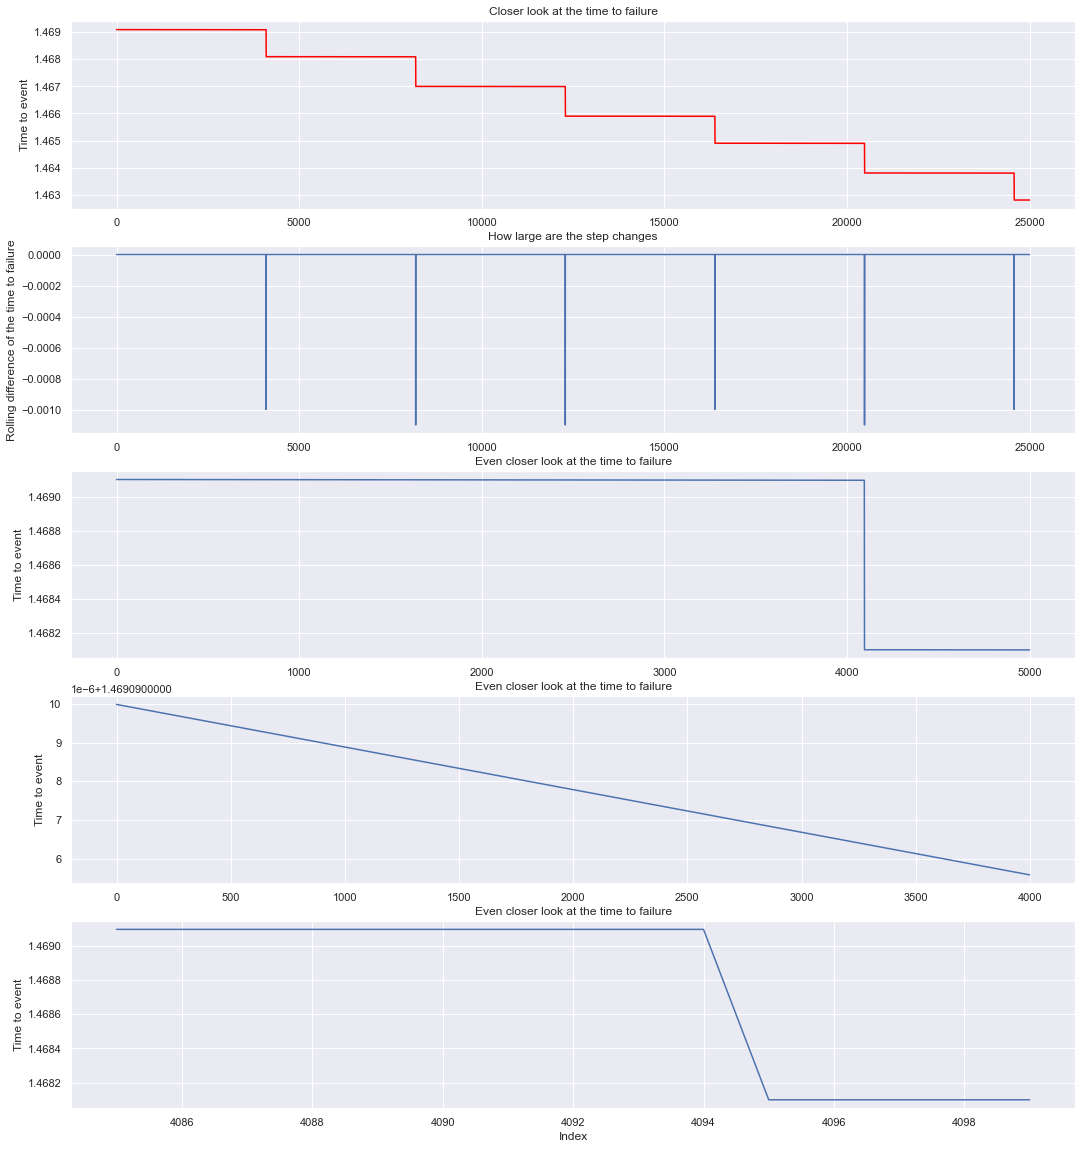

In [11]:
fig, ax = plt.subplots(5,1, figsize=(18,20))

ax[0].plot(df.index.values[0:25000], df.time_to_failure.values[0:25000], c="Red")
#ax[0].set_xlabel("Index")
ax[0].set_ylabel("Time to event")
ax[0].set_title("Closer look at the time to failure")

ax[1].plot(df.index.values[0:24999], np.diff(df.time_to_failure.values[0:25000]))
#ax[1].set_xlabel("Index")
ax[1].set_ylabel("Rolling difference of the time to failure")
ax[1].set_title("How large are the step changes")

ax[2].plot(df.index.values[0:5000], df.time_to_failure.values[0:5000])
#ax[2].set_xlabel("Index")
ax[2].set_ylabel("Time to event")
ax[2].set_title("Even closer look at the time to failure")

ax[3].plot(df.index.values[0:4000], df.time_to_failure.values[0:4000])
#ax[3].set_xlabel("Index")
ax[3].set_ylabel("Time to event")
ax[3].set_title("Even closer look at the time to failure")

ax[4].plot(df.index.values[4085:4100], df.time_to_failure.values[4085:4100])
ax[4].set_xlabel("Index")
ax[4].set_ylabel("Time to event")
ax[4].set_title("Even closer look at the time to failure")

- There appear to be step changes in the ttf data with a stable trend between the steps. 
- The step changes are not the same size.
- Looking closer at the stable trend between the step changes, the data is actually decreasing at a very small rate.

- Below I am reducing the size of the data to 1% in order to manage the load on memory and processing.

##### .values[::100] changes the df column to a numpy array, but not sure the use of [::100]
##### the [::100] indicates to create an array of values skipping 99 observations to create 1% of the data

train_acoustic_arr = df['acoustic_data'].values[::100]
time_to_failure_arr = df['time_to_failure'].values[::100]

In [12]:
# Can take a random integer by creating a list of random indices every 100 samples
# Can then use those random samples with .iloc[] to select only those indices
from random import *

acc = 0
rand_samps = []
for x in range(0, len(df), 100):
    r = randint(0, 100)
    acc = r + x
    if acc > len(df):
        acc = len(df) - 1
    rand_samps.append(acc)


In [13]:
df_new = df.iloc[rand_samps]

In [14]:
train_acoustic_arr = df_new['acoustic_data']
time_to_failure_arr = df_new['time_to_failure']

In [15]:
print(len(train_acoustic_arr), len(df)*0.01)

6291455 6291454.8


In [16]:
%%time
df.iloc[621985672:621985674]

Wall time: 1e+03 µs


,acoustic_data,time_to_failure
621985672,10,0.000595512439299999995525
621985673,2,11.618600019000000500568603


* Calculate the rolling difference of the time to failure to identify the step increases in value (delta_ttf>0), which indicate an experimental earthquake. Based on the 

In [17]:
%%time
df_diff = df.time_to_failure.diff()
df_diff.head(10)

Wall time: 28 s


0                           NaN
1   -0.000000001100000091014408
2   -0.000000001099999868969803
3   -0.000000001100000091014408
4   -0.000000001099999868969803
5   -0.000000001100000091014408
6   -0.000000001100000091014408
7   -0.000000001099999868969803
8   -0.000000001100000091014408
9   -0.000000001099999868969803
Name: time_to_failure, dtype: float64

In [18]:
len(df_diff)

629145480

In [19]:
quake_ind = df_diff.loc[df_diff > 0]

In [20]:
quake_ind

5656574      11.540004507177050285804398
50085878     14.179904507825289883271580
104677356     8.855904506336079506922943
138772453    12.692904507131899549676746
187641820     8.054904506145900811020510
218652630     7.057904505904599723464798
245829585    16.106904507467007192644814
307838917     7.904904506085149940020074
338276287     9.636904506474079923350473
375377848    11.425904506611239241919975
419368880    11.024004506283079152240134
461811623     8.828004506336833756563465
495800225     8.565904506238307902776796
528777115    14.750904507492730743933862
585568144     9.458904506387009192280857
621985673    11.618004506560700050954438
Name: time_to_failure, dtype: float64

In [21]:
len(quake_ind)

16

- Calculate the rolling difference of the time to failure to identify the step increases in value (delta_ttf>0), which indicate an experimental earthquake. Based on the code above, there are 16 simulated earthquake events present in the data.

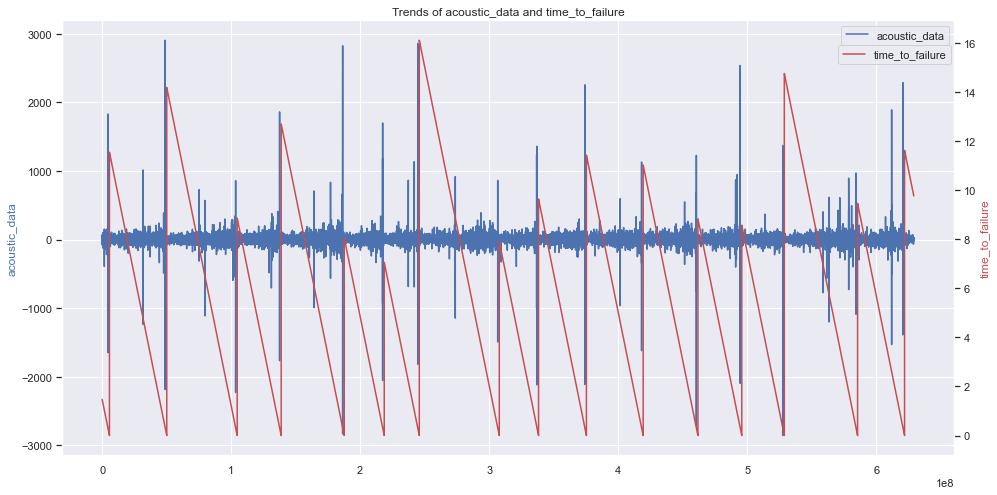

In [22]:
fig, ax1 = plt.subplots(figsize=(16,8))
plt.title("Trends of acoustic_data and time_to_failure")
plt.plot(train_acoustic_arr, color='b')
ax1.set_ylabel('acoustic_data', color='b')
plt.legend(['acoustic_data'])
ax2=ax1.twinx()
plt.plot(time_to_failure_arr, color='r')
ax2.set_ylabel('time_to_failure', color='r')
plt.legend(['time_to_failure'], loc=(0.87,0.9))
plt.grid(False)


In [23]:
df_rdc = pd.DataFrame()
df_rdc.loc[:,'acoustic_data'] = train_acoustic_arr
df_rdc.loc[:,'ttf'] = time_to_failure_arr

In [24]:
df_rdc.head()

,acoustic_data,ttf
60,4,1.469099917200000104955393
125,1,1.469099845699999962178595
234,2,1.469099725800000033615333
302,5,1.469099651000000061884521
454,8,1.469099483799999994459995


Text(0.5, 1.0, 'Signal distribution')

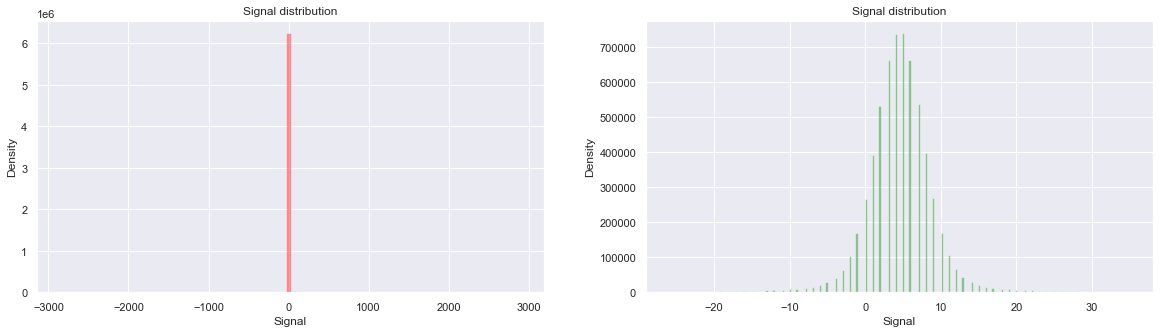

In [25]:
fig, ax = plt.subplots(1, 2, figsize=[20,5])
sns.distplot(df_rdc.acoustic_data.values, ax=ax[0], color="Red", bins=100, kde=False)
ax[0].set_xlabel("Signal")
ax[0].set_ylabel("Density")
ax[0].set_title("Signal distribution")

min_val = df_rdc.acoustic_data.mean() - 3 * df_rdc.acoustic_data.std()
max_val = df_rdc.acoustic_data.mean() + 3 * df_rdc.acoustic_data.std()
sns.distplot(df_rdc.loc[(df_rdc.acoustic_data >= min_val) & (df_rdc.acoustic_data <= max_val), "acoustic_data"].values, 
             ax=ax[1], 
             color="Green", 
             bins=200, 
             kde=False)
ax[1].set_xlabel("Signal")
ax[1].set_ylabel("Density")
ax[1].set_title("Signal distribution")

- The signal distribution with spikes in the data vs. the signal distribution w/out spikes.
- When reducing the data to within 3 std of the mean, the data displays a normal distribution.

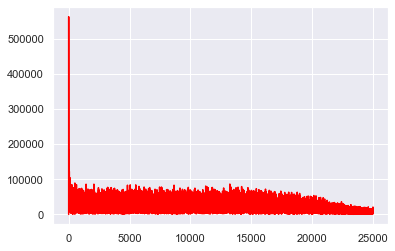

In [26]:
import scipy.signal as sg

ad = df_rdc['acoustic_data'].values
ad = ad - np.mean(ad)  # remove DC component, otherwise it dominates the plot

b, a = sg.butter(6, Wn=20000 / round(len(df_rdc)/2))
ad = sg.lfilter(b, a, ad)

zc = np.fft.fft(ad)
#zc = zc[:round(len(df_rdc)/2)]  # eliminate aliased portion of signal per Nyquist criteria
zc = zc[:25000]

realFFT = np.real(zc)
imagFFT = np.imag(zc)
magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)

plt.plot(magFFT, color="Red")

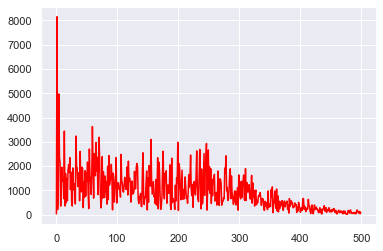

In [27]:
ad = df_rdc.iloc[2450000:2550000]['acoustic_data'].values
ad = ad - np.mean(ad)  # remove DC component, otherwise it dominates the plot

b, a = sg.butter(6, Wn=20000 / round(len(df_rdc)/2))
ad = sg.lfilter(b, a, ad)

zc = np.fft.fft(ad)
#zc = zc[:round(len(df_rdc)/2)]  # eliminate aliased portion of signal per Nyquist criteria
zc = zc[:500]

realFFT = np.real(zc)
imagFFT = np.imag(zc)
magFFT = np.sqrt(realFFT ** 2 + imagFFT ** 2)

plt.plot(magFFT, color="Red")

- The data is not showing any dominant frequency in the signal. It appears mostly made up of noise as expected.
- A rolling FFT (aka "waterfall FFT") may be interesting to determine if a dominant frequency is present near or around the experimental earthquake events.

In [28]:
def classic_sta_lta(x, sta_window, lta_window):
    """
    The Short Term Averaging/Long Term Averaging (STA/LTA) has been widely used to detect earthquake arrival time. 
    The method simply calculates the ratio of moving average of the waveform amplitude at short and long-time windows.
    """
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[sta_window:] = sta[sta_window:] - sta[:-sta_window]
    sta /= sta_window
    lta[lta_window:] = lta[lta_window:] - lta[:-lta_window]
    lta /= lta_window

    # Pad zeros
    sta[:lta_window - 1] = 0

    # Avoid division by zero by setting zero values to tiny float
    dtiny = np.finfo(0.0).tiny
    idx = lta < dtiny
    lta[idx] = dtiny

    return sta / lta

In [29]:
window_sizes = [896, 1792, 10000, 50000]
for wind in window_sizes:
    df_rdc['sm_avg_ser_' + str(wind)] = df_rdc['acoustic_data'].rolling(window=wind).mean()
    df_rdc['sm_std_ser_' + str(wind)] = df_rdc['acoustic_data'].rolling(window=wind).std()

In [30]:
df_rdc['rolling_q25'] = df_rdc['acoustic_data'].rolling(window=50000).quantile(0.25)
df_rdc['rolling_q50'] = df_rdc['acoustic_data'].rolling(window=50000).quantile(0.50)
df_rdc['rolling_q75'] = df_rdc['acoustic_data'].rolling(window=50000).quantile(0.75)
df_rdc['rolling_iqr'] = df_rdc.rolling_q75 - df_rdc.rolling_q25
df_rdc['rolling_min'] = df_rdc['acoustic_data'].rolling(window=50000).min()
df_rdc['rolling_max'] = df_rdc['acoustic_data'].rolling(window=50000).max()
df_rdc['rolling_kurtosis'] = df_rdc['acoustic_data'].rolling(window=50000).kurt()
df_rdc['rolling_skew'] = df_rdc['acoustic_data'].rolling(window=50000).skew()


In [31]:
df_rdc['classic_sta_lta1_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 500, 10000)
df_rdc['classic_sta_lta2_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 10000, 50000)
df_rdc['classic_sta_lta3_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 3333, 6666)
df_rdc['classic_sta_lta4_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 10000, 25000)
df_rdc['classic_sta_lta5_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 50, 1000)
df_rdc['classic_sta_lta6_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 100, 5000)
df_rdc['classic_sta_lta7_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 333, 666)
df_rdc['classic_sta_lta8_mean'] = classic_sta_lta(df_rdc['acoustic_data'], 4000, 10000)

In [32]:
df_rdc['classic_sta_lta1_mean'] = df_rdc['classic_sta_lta1_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta2_mean'] = df_rdc['classic_sta_lta2_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta3_mean'] = df_rdc['classic_sta_lta3_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta4_mean'] = df_rdc['classic_sta_lta4_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta5_mean'] = df_rdc['classic_sta_lta5_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta6_mean'] = df_rdc['classic_sta_lta6_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta7_mean'] = df_rdc['classic_sta_lta7_mean'].rolling(window=50000).mean()
df_rdc['classic_sta_lta8_mean'] = df_rdc['classic_sta_lta8_mean'].rolling(window=50000).mean()

In [33]:
df_rdc.dropna(inplace = True)
df_rdc = df_rdc.reset_index(drop = True)

- Have to drop null values created by the rolling functions above.

In [34]:
sm_avg_arr_896 = df_rdc['sm_avg_ser_896'].values
sm_std_arr_896 = df_rdc['sm_std_ser_896'].values

sm_avg_arr_1792 = df_rdc['sm_avg_ser_1792'].values
sm_std_arr_1792 = df_rdc['sm_std_ser_1792'].values

sm_avg_arr_10000 = df_rdc['sm_avg_ser_10000'].values
sm_std_arr_10000 = df_rdc['sm_std_ser_10000'].values

sm_avg_arr_50000 = df_rdc['sm_avg_ser_50000'].values
sm_std_arr_50000 = df_rdc['sm_std_ser_50000'].values


- Creating simple moving averages and standard deviations with different window sizes to determine possible best window size.

Text(0, 0.5, 'Simple moving std of window size 50000')

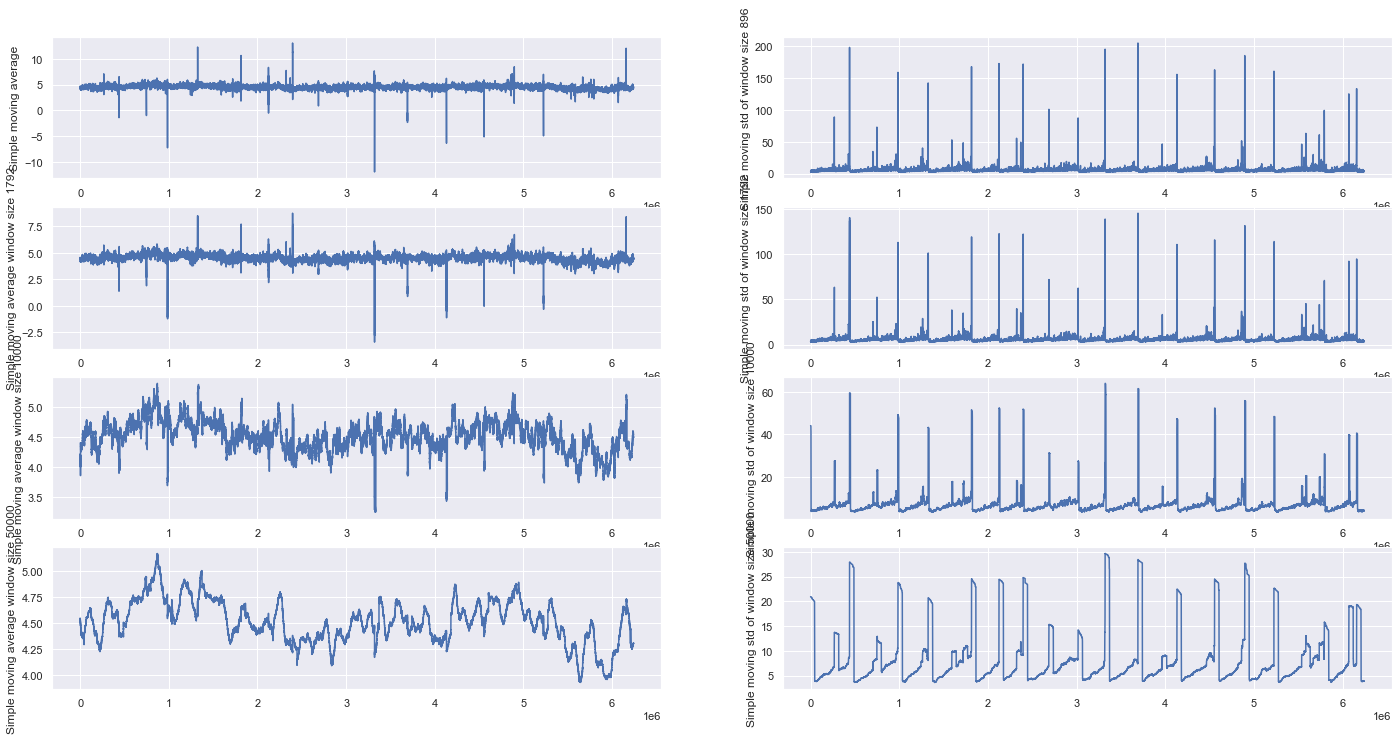

In [36]:
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(24,12))

axs[0,0].plot(sm_avg_arr_896, color='b')
axs[0,0].set_ylabel("Simple moving average")

axs[0,1].plot(sm_std_arr_896,color='b')
axs[0,1].set_ylabel("Simple moving std of window size 896")

axs[1,0].plot(df_rdc.sm_avg_ser_1792, color='b')
axs[1,0].set_ylabel("Simple moving average window size 1792")

axs[1,1].plot(sm_std_arr_1792,color='b')
axs[1,1].set_ylabel("Simple moving std of window size 1792")

axs[2,0].plot(df_rdc.sm_avg_ser_10000, color='b')
axs[2,0].set_ylabel("Simple moving average window size 10000")

axs[2,1].plot(sm_std_arr_10000,color='b')
axs[2,1].set_ylabel("Simple moving std of window size 10000")

axs[3,0].plot(df_rdc.sm_avg_ser_50000, color='b')
axs[3,0].set_ylabel("Simple moving average window size 50000")

axs[3,1].plot(sm_std_arr_50000,color='b')
axs[3,1].set_ylabel("Simple moving std of window size 50000")

#ax2 = ax1.twinx()
#plt.plot(sm_std_arr, color='lightgreen')
#ax2.set_ylabel("simple moving standard deviation")
#plt.grid(False)



#plt.plot(df_5pct['sm_avg_ser_56'])
#plt.plot(df_5pct['sm_avg_ser_224'])
#plt.plot(df_5pct['sm_avg_ser_896'])

In [37]:
df_rdc.columns

Index(['acoustic_data', 'ttf', 'sm_avg_ser_896', 'sm_std_ser_896',
       'sm_avg_ser_1792', 'sm_std_ser_1792', 'sm_avg_ser_10000',
       'sm_std_ser_10000', 'sm_avg_ser_50000', 'sm_std_ser_50000',
       'rolling_q25', 'rolling_q50', 'rolling_q75', 'rolling_iqr',
       'rolling_min', 'rolling_max', 'rolling_kurtosis', 'rolling_skew',
       'classic_sta_lta1_mean', 'classic_sta_lta2_mean',
       'classic_sta_lta3_mean', 'classic_sta_lta4_mean',
       'classic_sta_lta5_mean', 'classic_sta_lta6_mean',
       'classic_sta_lta7_mean', 'classic_sta_lta8_mean'],
      dtype='object')

In [38]:
diff_ser = df_rdc.ttf.diff()
event_ser = diff_ser.loc[diff_ser > 0]
event_ser

6567       11.540004388076571473220611
450860     14.179904389924999463801214
996775      8.855904329236070182673757
1337726    12.692904359031901506682516
1826419     8.054904356545920407484118
2136527     7.057904406904900618258125
2408297    16.106904427966959758578014
3028390     7.904904424684949582058380
3332764     9.636904333773999908885344
3703779    11.425904349311169383440756
4143690    11.024004378882500176928261
4568117     8.828004334736849756382071
4908003     8.565904381937892608789298
5237772    14.750904352892549198372762
5805682     9.458904404086899475601058
6169858    11.618004437560358610426192
Name: ttf, dtype: float64

- Use 2458296 index to create the plots around the earthquake event.

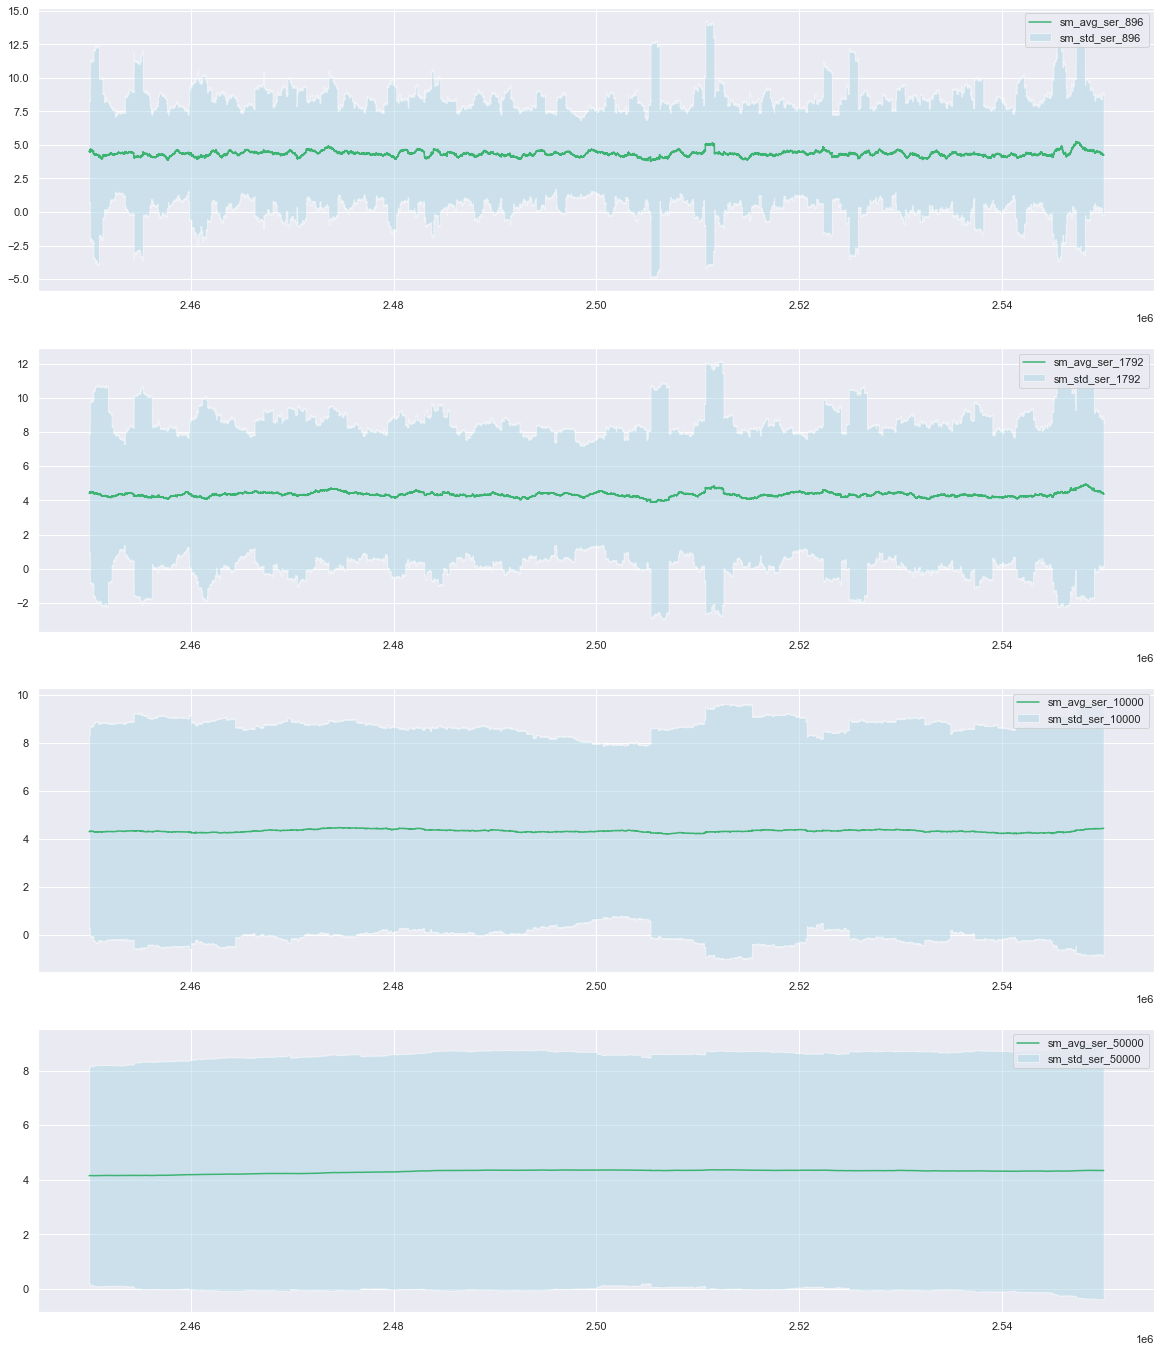

In [39]:
fig, ax = plt.subplots(len(window_sizes),1,figsize=(20,6*len(window_sizes)))

n=0
for col in df_rdc:
    for win in window_sizes:
        if 'sm_avg_ser_' + str(win) in col:
            avg_ser = df_rdc.iloc[2450000:2550000][col]
            ax[n].plot(avg_ser, label=col, color='mediumseagreen')
        if 'sm_std_ser_' + str(win) in col:
            std_ser = df_rdc.iloc[2450000:2550000][col]
            ax[n].fill_between(avg_ser.index.values, avg_ser.values - std_ser, avg_ser.values + std_ser,
                              facecolor='lightblue', alpha=0.5, label=col)
            ax[n].legend()
            n=n+1


#mean_df = df_rdc.iloc[4435000:4445000]['sm_avg_ser_14']
#std_df = df_rdc.iloc[4435000:4445000]["sm_std_ser_14"].values

#ax[0].plot(mean_df, label="sm_avg_ser_14", color="mediumseagreen")
#ax[0].fill_between(mean_df.index.values, mean_df.values - std_df, mean_df.values + std_df, 
 #                  facecolor='lightgreen', alpha=0.5, label="sm_avg_ser_14")
#ax[0].legend()

#mean_df = df_rdc.iloc[4435000:4445000]['sm_avg_ser_56']
#std_df = df_rdc.iloc[4435000:4445000]["sm_std_ser_56"].values

#ax[1].plot(mean_df, label="sm_avg_ser_56", color="mediumseagreen")
#ax[1].fill_between(mean_df.index.values, mean_df.values - std_df, mean_df.values + std_df, 
  #                 facecolor='lightgreen', alpha=0.5, label="sm_avg_ser_56")
#ax[1].legend()

In [40]:
df_rdc.head()

,acoustic_data,ttf,sm_avg_ser_896,sm_std_ser_896,sm_avg_ser_1792,sm_std_ser_1792,sm_avg_ser_10000,sm_std_ser_10000,sm_avg_ser_50000,sm_std_ser_50000,...,rolling_kurtosis,rolling_skew,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,classic_sta_lta5_mean,classic_sta_lta6_mean,classic_sta_lta7_mean,classic_sta_lta8_mean
0,5,0.171096825119999990105768,4.515625000000000000000000,3.319113641182390939121660,4.348772321428571174806166,3.761675834046685817924072,4.201900000000000190425453,44.188647864015919708435831,4.544039999999999857038802,20.925717626680430782926123,...,3086.696969419086144625907764,2.342678653161652135850090,0.884315728404862499978378,0.000085931909522093884407,0.886024122836392757918134,0.620192130802348584595052,0.979122080753844770129035,0.906785272380855267293498,0.977863127876698157159296,0.877189114097756572618891
1,9,0.171096805319999989425384,4.518973214285714412596917,3.322124489428204263674616,4.352120535714285587403083,3.763144611317313259490902,4.202099999999999724309419,44.188665055667094350155821,4.544139999999999623980784,20.925726973784872342321250,...,3086.691404255566339998040348,2.342661370363113171322311,0.884316040125000535354616,0.000171863714990262001197,0.886024427055381869067219,0.620239361937960698156758,0.979139579711476359946687,0.906794906705395642454448,0.977883166855640029169194,0.877189655143759017263960
2,6,0.171096664519999996922905,4.521205357142856762209249,3.322447287108247770959224,4.354910714285714412596917,3.762511366668201073792943,4.202300000000000146371804,44.188668666908817783678387,4.544240000000000279101187,20.925721983702523232295789,...,3086.694306607606904435670003,2.342648813214388781034359,0.884316352250892556696726,0.000257795476508444580677,0.886024731315852354107676,0.620286593150961018672263,0.979157314774747322694282,0.906804574134796870232833,0.977903196282760345248164,0.877190196278040068555981
3,4,0.171096578720000003226431,4.525669642857143237790751,3.319051085730855277233786,4.356026785714285587403083,3.762109048802747768291965,4.201800000000000423483471,44.188642662725357013187022,4.544279999999999652970928,20.925719031754685062196586,...,3086.696032117288723384262994,2.342644105430329748429585,0.884316664377814198871874,0.000343726909532387429457,0.886025035600840338290141,0.620333824192278004971968,0.979175203610243016782988,0.906814294658252029179835,0.977923227638169190178985,0.877190737414106580516204
4,11,0.171096473120000008849573,4.534598214285714412596917,3.325696038428404222031531,4.362165178571428825193834,3.763971167503487258443329,4.202700000000000102318154,44.188689466170721686921752,4.544400000000000439115411,20.925738848865712782298942,...,3086.684274548013490857556462,2.342620832533171881806311,0.884316978634745454179722,0.000429658493062829252053,0.886025340130344951639074,0.620381055296685635092047,0.979194287774991067863084,0.906824232238115812698709,0.977943289071938948175955,0.877191278762683657177490


- Plot the new features.

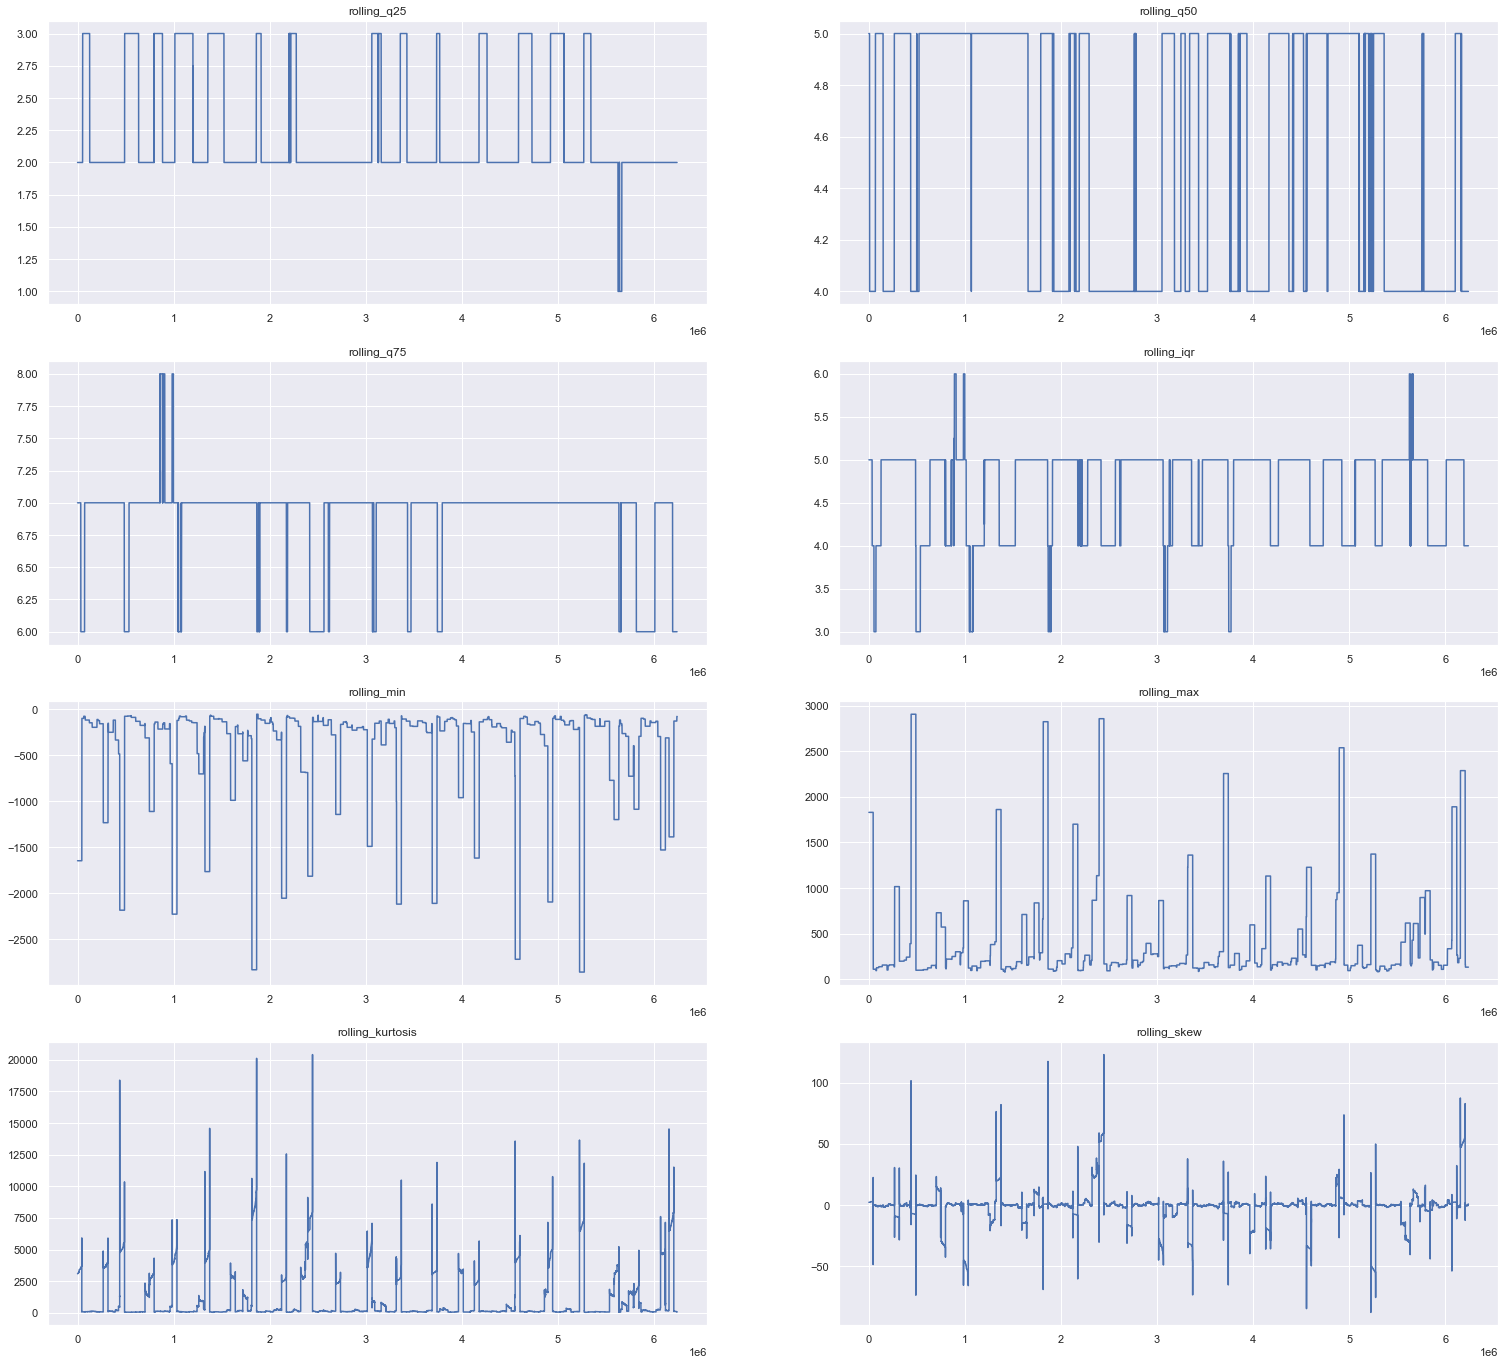

In [41]:
plt.figure(figsize=(26,24))

c = 0
for i, col in enumerate(df_rdc.columns):
    if "rolling_" in col:
        plt.subplot(4, 2, c+1)
        plt.plot(df_rdc[col], color="b")
        plt.title(col)
        c = c+1

# Modeling

- Test data .csv files are useless as we do not have the time to failure data to accompany the acoustic signals.

In [42]:
df_rdc.columns

Index(['acoustic_data', 'ttf', 'sm_avg_ser_896', 'sm_std_ser_896',
       'sm_avg_ser_1792', 'sm_std_ser_1792', 'sm_avg_ser_10000',
       'sm_std_ser_10000', 'sm_avg_ser_50000', 'sm_std_ser_50000',
       'rolling_q25', 'rolling_q50', 'rolling_q75', 'rolling_iqr',
       'rolling_min', 'rolling_max', 'rolling_kurtosis', 'rolling_skew',
       'classic_sta_lta1_mean', 'classic_sta_lta2_mean',
       'classic_sta_lta3_mean', 'classic_sta_lta4_mean',
       'classic_sta_lta5_mean', 'classic_sta_lta6_mean',
       'classic_sta_lta7_mean', 'classic_sta_lta8_mean'],
      dtype='object')

In [43]:
from sklearn.model_selection import train_test_split

# Define the X and y for the model

X = df_rdc[['sm_avg_ser_896', 'sm_std_ser_896', 
            'sm_avg_ser_1792', 'sm_std_ser_1792', 
            'sm_avg_ser_10000', 'sm_std_ser_10000', 
            'sm_avg_ser_50000', 'sm_std_ser_50000', 
            'rolling_q25', 'rolling_q50',
            'rolling_q75', 'rolling_iqr', 
            'rolling_min', 'rolling_max',
            'rolling_kurtosis', 'rolling_skew',
            'classic_sta_lta1_mean', 'classic_sta_lta2_mean',
            'classic_sta_lta3_mean', 'classic_sta_lta4_mean',
            'classic_sta_lta5_mean', 'classic_sta_lta6_mean',
            'classic_sta_lta7_mean', 'classic_sta_lta8_mean']]
y = df_rdc.ttf
X_train, X_test, y_tr, y_test = train_test_split(X, y, test_size=.2, random_state=123)

In [44]:
X.tail()

,sm_avg_ser_896,sm_std_ser_896,sm_avg_ser_1792,sm_std_ser_1792,sm_avg_ser_10000,sm_std_ser_10000,sm_avg_ser_50000,sm_std_ser_50000,rolling_q25,rolling_q50,...,rolling_kurtosis,rolling_skew,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,classic_sta_lta5_mean,classic_sta_lta6_mean,classic_sta_lta7_mean,classic_sta_lta8_mean
6241451,4.553571428571428825193834,3.440707438500962833671792,4.535156250000000000000000,3.210794986034299025590144,4.503400000000000069633188,3.849528585016428472442840,4.307500000000000106581410,3.834391451214587576146187,2.0,4.0,...,58.105630699588758147910994,0.863234289512842645208934,0.992305814910133587858354,0.721890298261289586889689,0.994470018565111857355987,1.015500454503251326343616,1.001785160106324124029697,0.995138533953494608397250,1.000300922258375413420595,0.996840973501130322986796
6241452,4.553571428571428825193834,3.440707438500962833671792,4.532924107142856762209249,3.211861868103822459374896,4.502500000000000390798505,3.849295449477947883565321,4.307520000000000237605491,3.834371590978297827945198,2.0,4.0,...,58.106857910681668499819352,0.863247573463970629958908,0.992306972013293653311905,0.721909477262917209650084,0.994465571172169160441001,1.015499493068758418701236,1.001771821954566599188752,0.995139423064677508534714,1.000300446754932792714499,0.996836840058696216360090
6241453,4.554687500000000000000000,3.441014582144434452715132,4.534040178571428825193834,3.212024062130953261373634,4.503000000000000113686838,3.849165183138625767611529,4.307559999999999611475232,3.834378814828994119778827,2.0,4.0,...,58.106362151911817193195020,0.863213127784123401831096,0.992308146579196859171645,0.721928658564890746163201,0.994461126298926800792799,1.015498539502990293925677,1.001759052583217624032841,0.995140475115817491058579,1.000300005062937813704593,0.996832696625955527736096
6241454,4.559151785714285587403083,3.441590017614399865664154,4.535156250000000000000000,3.212533484367642522272490,4.502699999999999924682470,3.848853605586165294027978,4.307620000000000004547474,3.834397473876598905206947,2.0,4.0,...,58.105123557254735544574942,0.863160515755536983384388,0.992309366332443043567935,0.721947836731156034062451,0.994456676537657346948151,1.015497587338096474596227,1.001746722885616946996379,0.995141903264420535357715,1.000299621431897767465102,0.996828556358466899567361
6241455,4.561383928571428825193834,3.442524713986252926645193,4.537946428571428825193834,3.212501720586342646157618,4.506899999999999906208359,3.828605256702115156031141,4.307640000000000135571554,3.834408909365976114713703,2.0,4.0,...,58.104380708004100597463548,0.863142349166474920352243,0.992310673086821970478866,0.721966943841022557037945,0.994452178440555889515906,1.015496567958810381071544,1.001734724382099983586158,0.995143372216664379159567,1.000299073968945018364707,0.996824478178295780850249


In [52]:
#scale data
from sklearn import preprocessing
import numpy as np

# build scaler based on training data and apply it to test data to then also scale the test data

scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X)

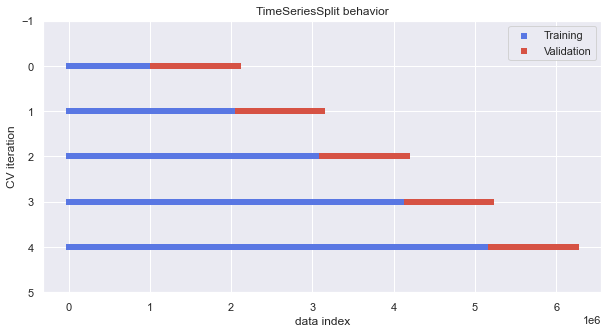

In [53]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=5)
fig, ax = plt.subplots(figsize=(10,5))

for ii, (tr, tt) in enumerate(cv.split(X, y)):
    l1 = ax.scatter(tr, [ii]*len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii]*len(tt), c=[plt.cm.coolwarm(0.9)], marker='_', lw=6)
    ax.set(ylim=[5, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])
    

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [59]:
def rf_performance(X_tt, y_tt, preds, fold_):
    """
    Calculate the scores for the random forest regressor predictions on both the test and train sets
    """
    
    r_2 = r2_score(y_tt, preds)
    MAE = mean_absolute_error(y_tt, preds)
    MSE = mean_squared_error(y_tt, preds)
    RMSE = np.sqrt(MSE)
    MAPE = mean_absolute_percentage_error(y_tt, preds)
        
    rf_scores = [fold_, r_2, MAE, MSE, RMSE, MAPE]
    #rf_scores = pd.DataFrame(rf_scores)
    #rf_scores.columns = ['fold', 'test_score', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
    #rf_scores.set_index('fold', inplace=True)
    
    return rf_scores

In [60]:
def rf_predict(X, y, mf: float=3, ne: float=10, msl: float=50):
    """
    Use a Random Forest Regressor to predict time to failure on both the train set and test set
    Return the scores and performance metrics of the prediction
    """
    feature_importance_df = pd.DataFrame()
    scores_tt = []
    scores_tr = []
    rf_params = {}
    train_columns = X.columns.values
    
    for fold_, (tr, tt) in enumerate(cv.split(X, y)):
        
        # train and test splits per fold
        X_tr, X_tt = X.iloc[tr,:], X.iloc[tt,:]
        y_tr, y_tt = y.iloc[tr], y.iloc[tt]
        
        # model 
        rf = RandomForestRegressor(max_features=mf, n_estimators=ne, min_samples_leaf=msl)
        rf.fit(X_tr, y_tr)
        preds = rf.predict(X_tt)
        preds_tr = rf.predict(X_tr)
        
        # performance scores
        scores_tt.append(rf_performance(X_tt=X_tt, y_tt=y_tt, preds=preds, fold_=fold_))
        scores_tr.append(rf_performance(X_tt=X_tr, y_tt=y_tr, preds=preds_tr, fold_=fold_))
        
        # feature importance
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = train_columns
        fold_importance_df["importance"] = rf.feature_importances_[:len(train_columns)]
        fold_importance_df["fold"] = fold_
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    return scores_tt, scores_tr, X_tr, X_tt, y_tr, y_tt, preds_tr, preds, feature_importance_df

In [61]:
def plot_rf(y_tt, preds):
    """
    Plot the resulting predictions against the train and test sets
    """
    fig = plt.figure(figsize=(18, 12))
    ax1 = fig.add_subplot(111)

    ax1.scatter(range(len(y_tt)), y_tt, s=10, c='b', marker="s", label='first')
    ax1.scatter(range(len(preds)), preds, s=10, c='r', marker="o", label='second', alpha=0.05)
    plt.legend(loc='upper left');
    
    plt.show()

In [93]:
scores_tt, scores_tr, X_tr, X_tt, y_tr, y_tt, preds_tr, preds, feature_importance_df = rf_predict(X=X, y=y)

In [94]:
scores_tt = pd.DataFrame(scores_tt)
scores_tt.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
scores_tt.set_index('fold', inplace=True)
scores_tt

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.364793426600777626056527,1.936401904719140087962614,6.220443655860578680005801,2.494081725978637198437582,3.241267084779253071502580
1,0.376606207961869499101226,2.858152319285812037463756,12.186462015234162947763252,3.490911344510794656059716,4.740027750016549745737393
2,0.040241322960601122460389,2.440778130142171153948993,9.287686719997440221163743,3.047570625924433063147490,4.168758366391308811671479
3,0.511006300657607992476983,1.557121836881484089332162,3.556374371644117626800607,1.885835192068521459773933,5.748848123242395580234643
4,0.334396802259207759355775,2.847131879980147051156791,11.002111560941834511595516,3.316943104869577663151858,4.918724073141024000221933


In [95]:
scores_tr = pd.DataFrame(scores_tr)
scores_tr.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
scores_tr.set_index('fold', inplace=True)
scores_tr

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.999829254395529609666937,0.003329175920284480321570,0.002449012358901571199954,0.049487496995721767800713,0.404935575873816344660838
1,0.999844655150229799644990,0.006108457711999785814949,0.001938749174763650410733,0.044031229539539890049937,0.152579051760055844910724
2,0.999866890493750215540558,0.004766216466421323641467,0.001981316471433312853545,0.044511981212178287903303,0.197337725407195296867258
3,0.999831208232120238754703,0.007284214515104346122920,0.002336079830780616196223,0.048333009742624305493663,0.258065200880924827675500
4,0.999860284276076427545377,0.005713401561613034619624,0.001768295375023895858388,0.042051104325854460341816,0.293559214626835707218078


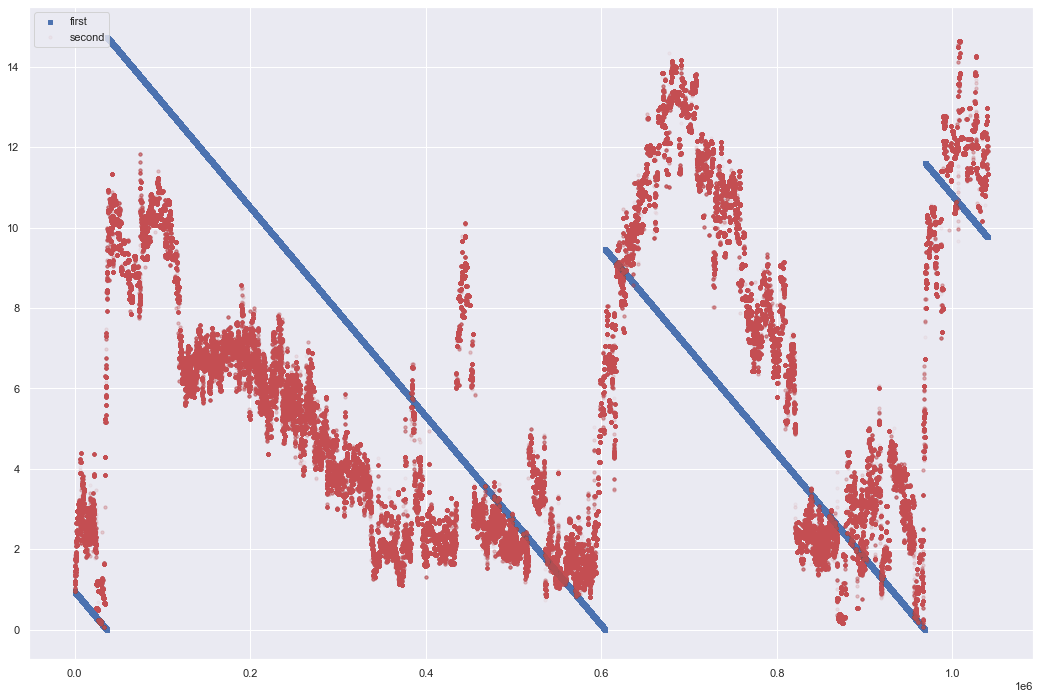

In [96]:
plot_rf(y_tt=y_tt, preds=preds)

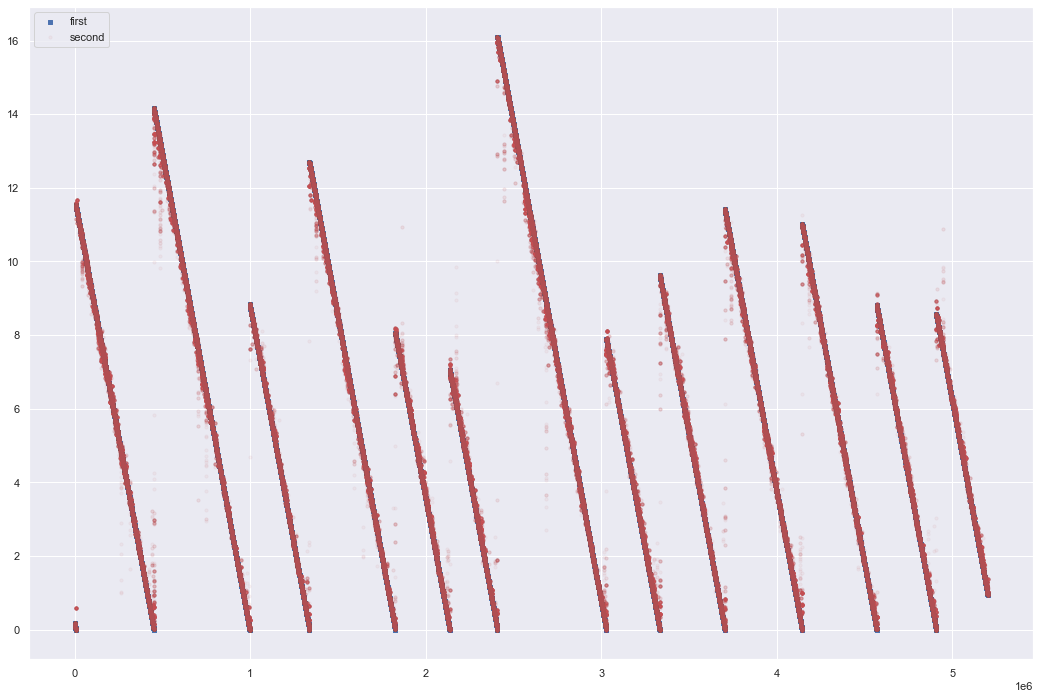

In [97]:
plot_rf(y_tt=y_tr, preds=preds_tr)

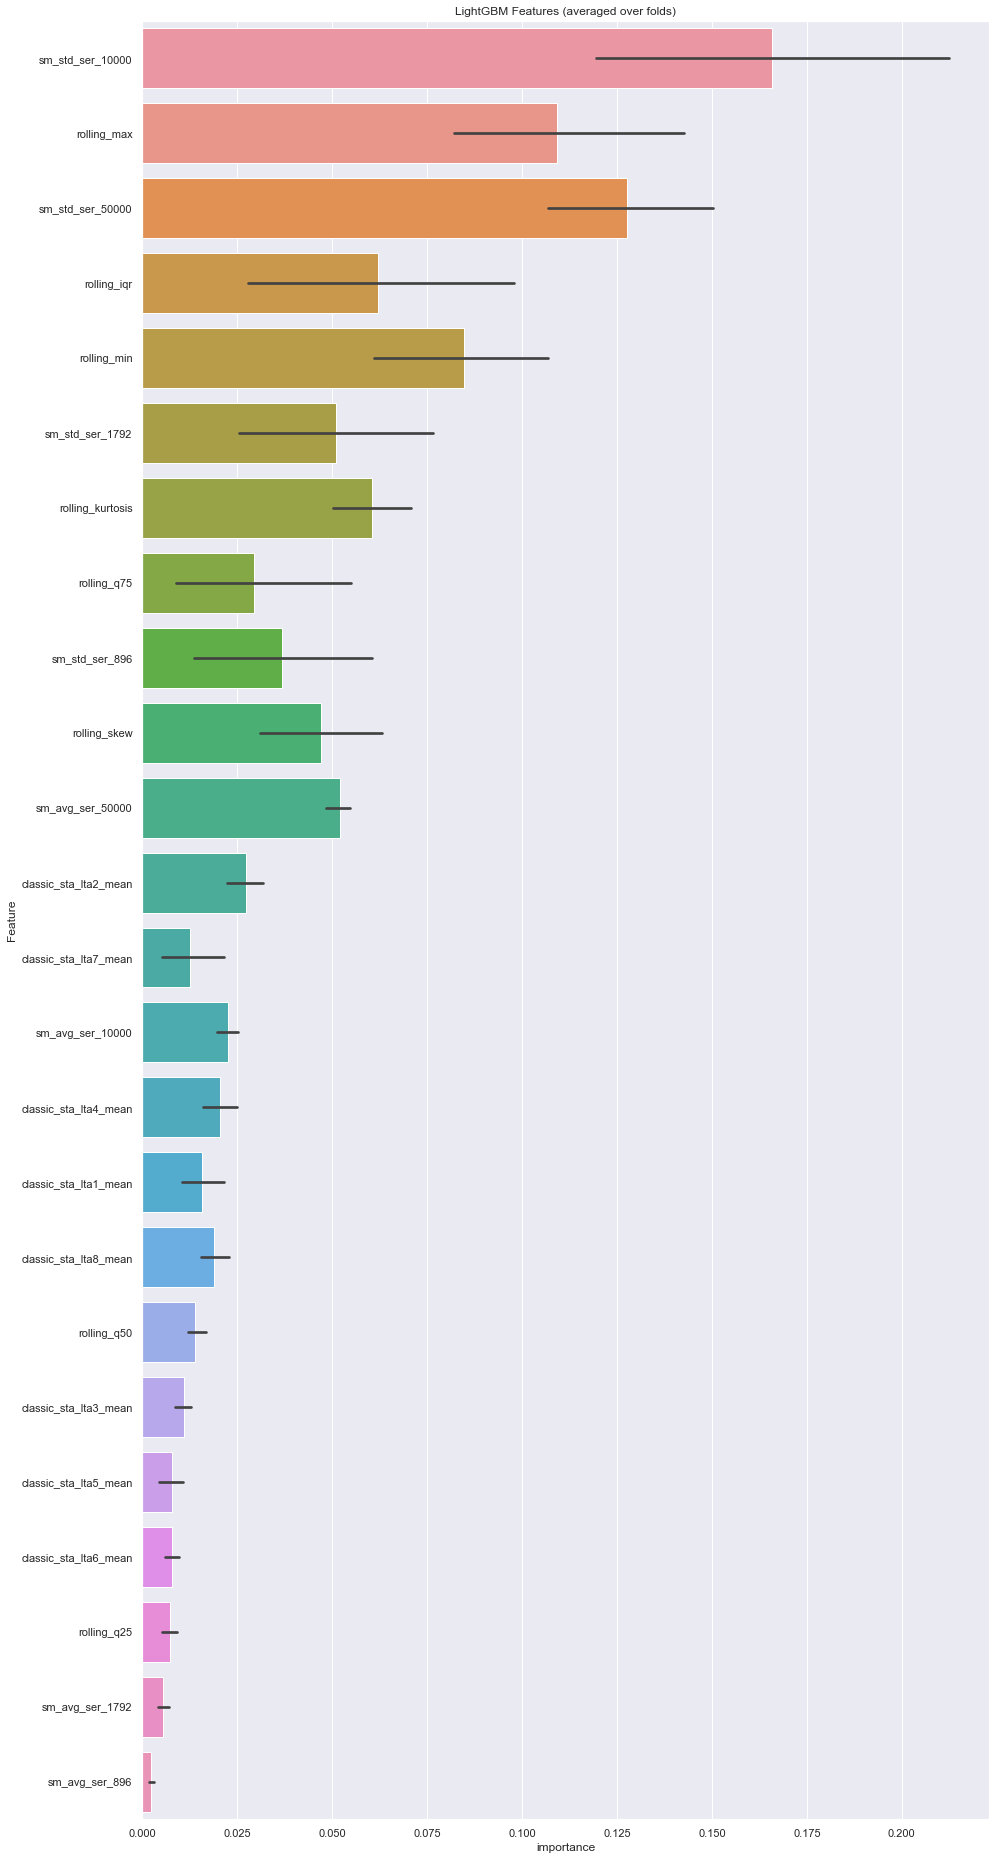

In [98]:
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False).index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,26))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('LightGBM Features (averaged over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

# Create a GridSearchCV on the msl

### Notes:
- Need to add a scoring parameter to the GridSearchCV
- Need to run 500 -> 10000 MSL grid search
- Need to run it without leakage (i.e. delete 50000 rows between train and test sets

## GridSearchCV w/ new X and y to prevent leakage and new TimeSeriesSplit on the refined data

In [99]:
#### Changed to Markdown Cell after completion so as not to reduce the series further
### Added to rf_predict_2
X_grid = X.iloc[0:4568118].append(X.iloc[4618119:])
y_grid = y.iloc[0:4568118].append(y.iloc[4618119:])

In [100]:
len(X), len(X_grid)

(6241456, 6191455)

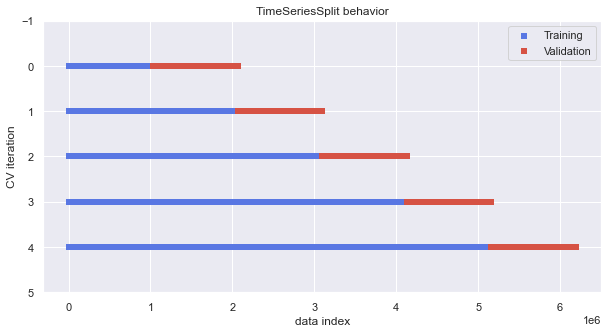

In [101]:
ts_gs_cv = TimeSeriesSplit(n_splits=5)
fig, ax = plt.subplots(figsize=(10,5))

for ii, (tr, tt) in enumerate(ts_gs_cv.split(X_grid, y_grid)):
    l1 = ax.scatter(tr, [ii]*len(tr), c=[plt.cm.coolwarm(.1)], marker='_', lw=6)
    l2 = ax.scatter(tt, [ii]*len(tt), c=[plt.cm.coolwarm(0.9)], marker='_', lw=6)
    ax.set(ylim=[5, -1], title='TimeSeriesSplit behavior', xlabel='data index', ylabel='CV iteration')
    ax.legend([l1, l2], ['Training', 'Validation'])

In [115]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor()
param_search = {'max_features' : [3],
                'n_estimators' : [100],
                'min_samples_leaf' : [x for x in range(500, 10000, 1000)]
               }

grid_search = GridSearchCV(estimator = rf_model, 
                           cv = ts_gs_cv, 
                           param_grid = param_search,
                           scoring = 'neg_root_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(X_grid,y_grid)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(),
             param_grid={'max_features': [3],
                         'min_samples_leaf': [500, 1500, 2500, 3500, 4500, 5500,
                                              6500, 7500, 8500, 9500],
                         'n_estimators': [100]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [116]:
grid_search.best_params_

{'max_features': 3, 'min_samples_leaf': 2500, 'n_estimators': 100}

In [117]:
grid_search.cv_results_

{'mean_fit_time': array([ 997.33385129,  908.0234304 ,  844.32503815,  781.14909678,
         755.52145553, 1074.30158868,  712.07954636,  693.2422246 ,
         680.75655341,  671.83448386]),
 'std_fit_time': array([553.5242415 , 508.66706101, 475.34601784, 436.03174143,
        431.19282559, 713.02247682, 409.47398543, 398.89606714,
        392.18468257, 390.51126098]),
 'mean_score_time': array([4.96992626, 4.46555905, 4.16549797, 3.81868496, 3.88023033,
        5.40472517, 3.52096424, 3.40186963, 3.32648258, 3.29206839]),
 'std_score_time': array([0.51294579, 0.48566784, 0.42863933, 0.35879994, 0.53536994,
        1.59139773, 0.36814305, 0.33944491, 0.37253517, 0.34410712]),
 'param_max_features': masked_array(data=[3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_leaf': masked_array(data=[500, 1500, 2500, 3500, 4500, 5

# Create a new X_tr and X_tt based off the 12th earthquake in the data
- The 12th earth quake is at index 4568118 (before reducing the dataset: 461811623)


In [118]:
df_diff = y.diff()
quake_ind = X.loc[df_diff > 0]

In [119]:
quake_ind

,sm_avg_ser_896,sm_std_ser_896,sm_avg_ser_1792,sm_std_ser_1792,sm_avg_ser_10000,sm_std_ser_10000,sm_avg_ser_50000,sm_std_ser_50000,rolling_q25,rolling_q50,...,rolling_kurtosis,rolling_skew,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,classic_sta_lta5_mean,classic_sta_lta6_mean,classic_sta_lta7_mean,classic_sta_lta8_mean
400861,4.814732142857143237790751,3.533597014534834990229228,4.790178571428571174806166,3.823807050432767695724579,4.458899999999999863575795,4.389787900775910856054907,4.393740000000000200941486,26.326190954618191142344585,2.0,4.0,...,3243.603453024550617556087673,2.065727082453631791025828,1.004335498702147555505348,1.873232251357150657256057,0.993418591359958913500350,1.339199904080907499448472,1.007676087560783972918443,1.016200404661707912268298,0.995829435495994785831897,0.991998552897809471318169
946775,4.827008928571428825193834,3.860440589659117627263640,4.906250000000000000000000,3.563749021886289281013660,5.030999999999999694466624,4.531522091890112236001187,4.859919999999999795647909,20.051921084633978153988210,2.0,5.0,...,1974.967111246657395895454101,-7.072856511516361521785257,1.042832051487675881773498,1.732021097841709877940275,1.006595656588273213216667,1.284704639861546260348746,0.996553006210750602633652,0.998392727972312599149518,0.990123912573295239525351,1.032389136867266410391153
1287726,4.746651785714285587403083,2.907799174561965571683686,4.768973214285714412596917,3.063478324988393897143624,4.700300000000000366640052,4.317886557617908849238120,4.693900000000000183320026,24.953675010064884531857388,2.0,5.0,...,5686.414056365352735156193376,19.376391840255902110357056,1.016313084115582965338831,1.464869937448405323721090,0.989317603924642186008498,1.220661798674335329906171,0.992960436975302895845630,1.011370621074676234840695,0.992512042397051152953225,1.002673672965610718321727
1776420,4.627232142857143237790751,3.931749512614269193022665,4.656250000000000000000000,3.577353703479863256120552,4.613000000000000433431069,4.711374608868172941811281,4.549019999999999619433311,27.815354589122570416748204,2.0,5.0,...,4765.794210168308381980750710,-33.322405824495980652955041,1.015225464907315577889335,1.718433611851505338208312,0.981335875605205854022017,1.286164125805958846626709,1.005369446712012448941209,1.022934772755819565759339,0.987969829893641904305923,1.004705033879034203891933
2086528,4.349330357142856762209249,2.859007054707323192133117,4.420200892857143237790751,3.199541836939735262035356,4.404799999999999826627572,4.261003705146949371851406,4.503580000000000360671493,24.818703159999252250145219,2.0,5.0,...,4125.692028889749963127542287,19.009918539557499883585479,1.084989761855542411694842,1.768617216409764880680200,0.993958524829602008132667,1.290659168788381494508144,0.985695888640803929980905,1.060850694279262151908938,0.992548012331743945146911,1.008290576754904854794859
2358298,3.771205357142857206298459,3.094795974063401011733276,3.994977678571428381104624,3.659499222737829793317132,4.118800000000000238742359,4.201029805319579146782871,4.196100000000000385114163,28.239599754421124799819154,2.0,4.0,...,10212.762088249170119524933398,53.306304481240964321386855,1.017619024773493974223015,1.685514967839353506207090,0.989033118599706662088522,1.253456208465395071982584,0.987174706429261528128905,0.979504704449538743382675,0.989592588918601800962449,1.009706212020679894081354
2978392,4.180803571428571174806166,3.826212127158199471921307,4.300781250000000000000000,3.983135786072548256697701,4.547200000000000130739863,4.950153791780907752695384,4.537560000000000037800874,22.609551368452098785155613,2.0,4.0,...,4840.688163757044094381853938,47.553964580847974730204442,0.974542548611238790279288,1.611471633802488589992663,0.977435031995487757505714,1.222055292058635833640778,0.999899921063479690808151,0.974149288758758724604547,0.993112247053559271670053,0.988615184834341742536878
3282765,4.408482142857143237790751,4.6562861379793964999862

In [120]:
4568118 + 50001

4618119

In [102]:
# Another predict function for manually set train and test sets
# Train and test sets are defined by the same values as the grid search
# No cross-fold validation

def rf_predict_2(X, y, mf: float=3, ne: float=10, msl: float=50):
    """
    Use a Random Forest Regressor to predict time to failure on both the train set and test set
    Return the scores and performance metrics of the prediction
    """
    feature_importance_df = pd.DataFrame()
    scores_tt = []
    scores_tr = []
    rf_params = {}
    train_columns = X.columns.values
    
        
    # train and test splits per fold
    X_tr, X_tt = X.iloc[0:4568118], X.iloc[4618119:]
    y_tr, y_tt = y.iloc[0:4568118], y.iloc[4618119:]
        
    # model 
    rf = RandomForestRegressor(max_features=mf, n_estimators=ne, min_samples_leaf=msl)
    rf.fit(X_tr, y_tr)
    preds = rf.predict(X_tt)
    preds_tr = rf.predict(X_tr)
    
    fold_ = 0
    # performance scores
    scores_tt.append(rf_performance(X_tt=X_tt, y_tt=y_tt, preds=preds, fold_=fold_))
    scores_tr.append(rf_performance(X_tt=X_tr, y_tt=y_tr, preds=preds_tr, fold_=fold_))
        
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = rf.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    return scores_tt, scores_tr, X_tr, X_tt, y_tr, y_tt, preds_tr, preds, feature_importance_df

# Model 1 - Random Forest Regression Model w/ gridsearch-cv best params

In [103]:
rf_scores_tt, rf_scores_tr, rf_X_tr, rf_X_tt, rf_y_tr, rf_y_tt, rf_preds_tr, rf_preds, feature_importance_df = rf_predict_2(X=X, y=y, ne=100, msl=2500)

In [104]:
rf_scores_tt = pd.DataFrame(rf_scores_tt)
rf_scores_tt.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
rf_scores_tt.set_index('fold', inplace=True)
rf_scores_tt

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.434425414026808565104432,2.378652922038009709382322,7.625509481434906255969963,2.76143250531945927406241,5.848784183099538402927919


In [105]:
rf_scores_tr = pd.DataFrame(rf_scores_tr)
rf_scores_tr.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
rf_scores_tr.set_index('fold', inplace=True)
rf_scores_tr

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.983693630760417159208941,0.288081972995110180413292,0.219400555235157362909959,0.468402129836273661833701,2.789257961083797088264191


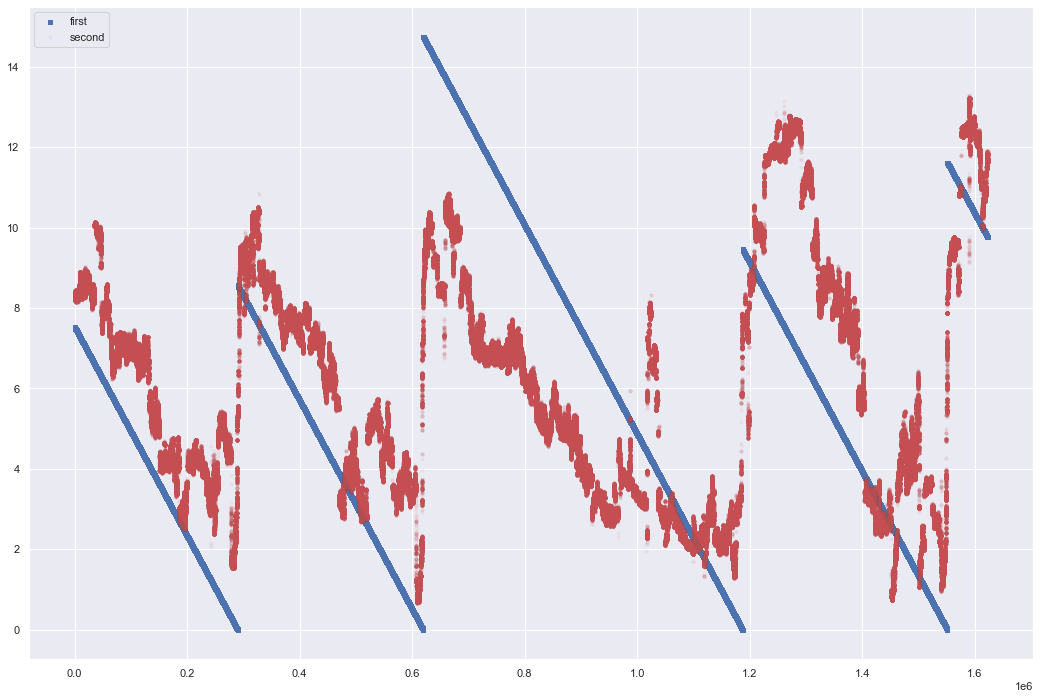

In [106]:
plot_rf(y_tt=rf_y_tt, preds=rf_preds)

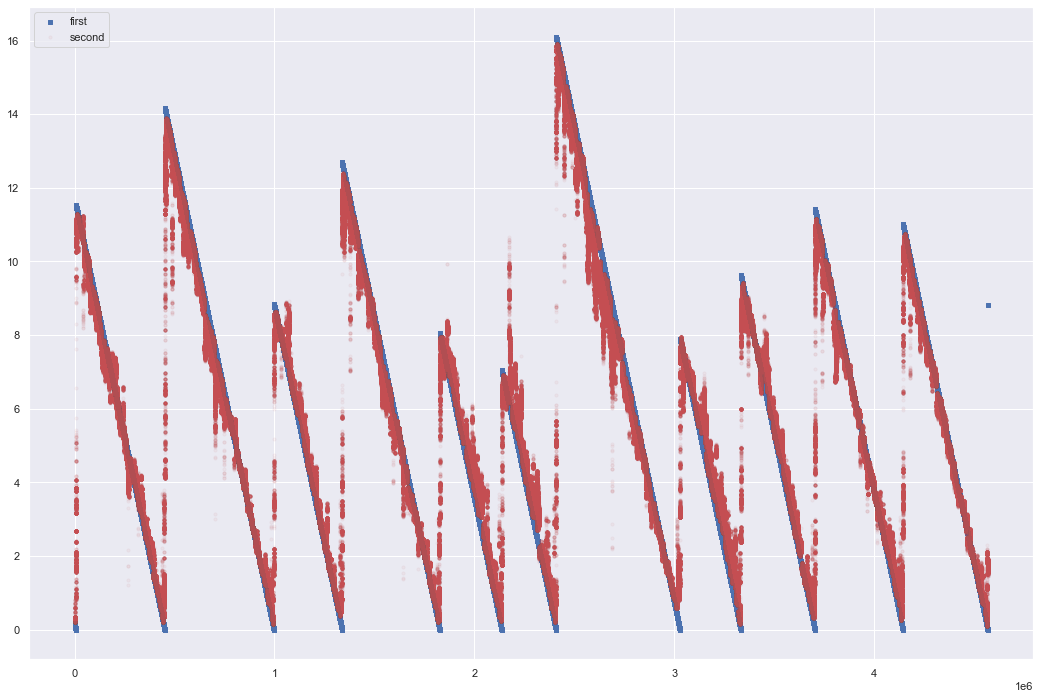

In [107]:
plot_rf(y_tt=rf_y_tr, preds=rf_preds_tr)

In [145]:
acoustic = df_rdc['acoustic_data']
len(acoustic)

6241456

In [143]:
len(np.append(rf_y_tr, rf_y_tt))

6191455

In [147]:
def plot_rf_2(y_tt, preds, start, end, ac_start, ac_end):
    acoustic = df_rdc['acoustic_data']
    
    fig = plt.figure(figsize=(18, 12))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()
    
    ax1.scatter(range(len(y_tt[start:end])), y_tt[start:end], s=10, c='b', marker="s", label='training ttf')
    ax1.scatter(range(len(preds[start:end])), preds[start:end], s=10, c='r', marker="o", label='prediction ttf', alpha=0.5)
    ax2.scatter(range(len(acoustic[ac_start:ac_end])), acoustic[ac_start:ac_end], s=10, c='g', marker="s", label='acoustic')
    ax1.legend(loc='upper left');
    ax2.legend(loc='upper right')
    
    plt.show()

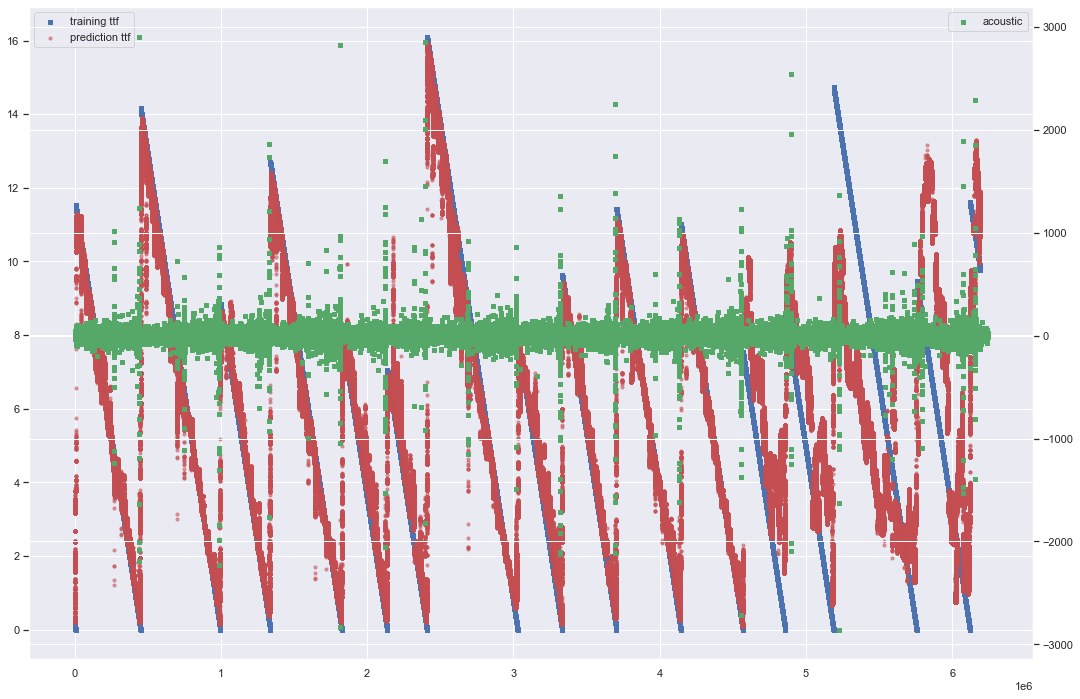

In [136]:
plot_rf_2(y_tt=np.append(rf_y_tr, rf_y_tt), preds=np.append(rf_preds_tr, rf_preds), start=0, end=len(np.append(rf_X_tr, rf_X_tt)))

## Closer look at the Training Data Events:

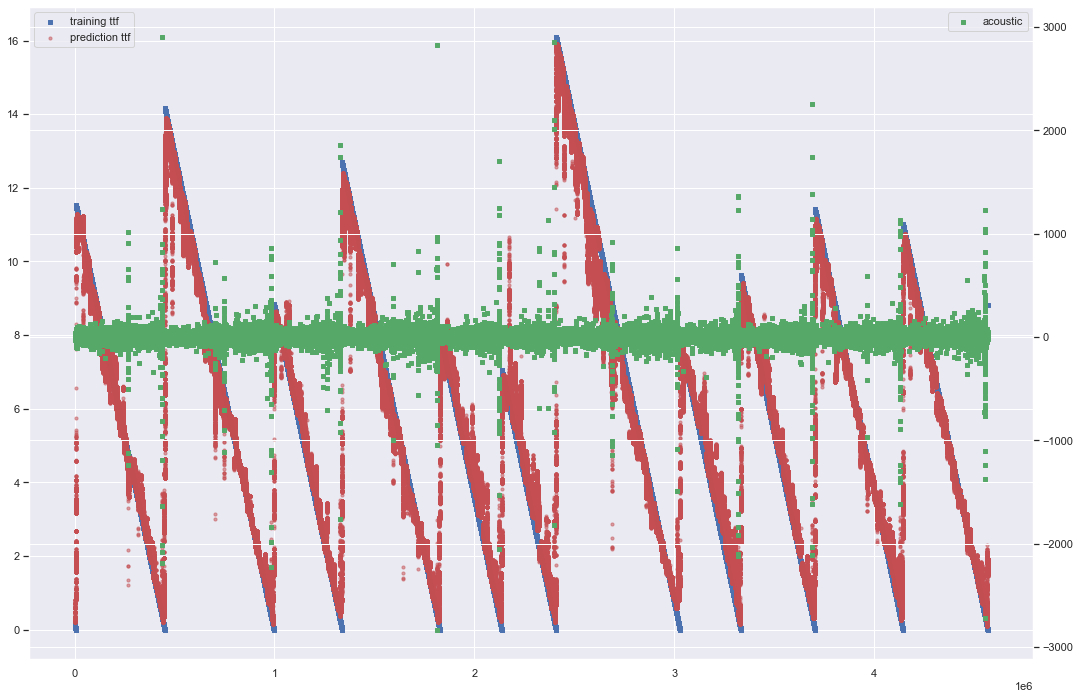

In [137]:
plot_rf_2(y_tt=rf_y_tr, preds=rf_preds_tr, start=0, end=len(rf_X_tr))

## Closer look at the TEST Data Events:

In [138]:
quake_y = rf_y_tr.append(rf_y_tt)
df_diff = quake_y.diff()
quake_ind = quake_y.loc[df_diff > 0]
quake_ind

6567       11.540799913000000742613338
450860     14.180599925999999300074705
996775      8.856699873700000225085205
1337726    12.693999891000000701524186
1826419     8.055499934000000195055691
2136527     7.058999948600000351461858
2408297    16.107399937000000278430889
3028390     7.905599971100000011858810
3332764     9.637099892800000233705759
3703779    11.426399983999999676598236
4143690    11.024199928999999897882844
4568117     8.828099956399999115319588
4908003     8.565999960299999216317701
5237772    14.751799954999999187066351
5805682     9.459499977300000139734948
6169858    11.618599960999999254340764
Name: ttf, dtype: float64

In [139]:
rf_X_tt

,sm_avg_ser_896,sm_std_ser_896,sm_avg_ser_1792,sm_std_ser_1792,sm_avg_ser_10000,sm_std_ser_10000,sm_avg_ser_50000,sm_std_ser_50000,rolling_q25,rolling_q50,...,rolling_kurtosis,rolling_skew,classic_sta_lta1_mean,classic_sta_lta2_mean,classic_sta_lta3_mean,classic_sta_lta4_mean,classic_sta_lta5_mean,classic_sta_lta6_mean,classic_sta_lta7_mean,classic_sta_lta8_mean
4618119,4.145089285714285587403083,4.531101509087803513864401,4.176339285714285587403083,4.159191068437880112185212,4.658800000000000274269496,3.978286721236647949240250,4.717999999999999971578291,3.935523569603402105343548,3.0,5.0,...,96.512268696687286251290061,-0.103519978207766635835974,0.984263877713806745184399,0.298995355537355289587964,0.997038197045728935563602,0.745013275900160976128461,0.999068140930229553475783,0.990740633516856594731337,0.999806529127640675191913,0.990099483272569025338328
4618120,4.142857142857143237790751,4.532158744886382706340555,4.175223214285714412596917,4.159775199460814754104376,4.658500000000000085265128,3.978449516570468524889748,4.717859999999999942588147,3.935531322264420150958131,3.0,5.0,...,96.511476106171798505783954,-0.103441106760915085827079,0.984263964522897438769178,0.299013635943415789775202,0.997037816783226560346520,0.745031680145135322135275,0.999027401945591808640756,0.990723554602837119809067,0.999797392628495873445615,0.990102086082051191517905
4618121,4.143973214285714412596917,4.532000120208337534677412,4.175781250000000000000000,4.159684528947493298289828,4.658299999999999663202743,3.978432342296954082883076,4.717900000000000204636308,3.935513861667326640514375,3.0,5.0,...,96.513241800071114084857982,-0.103466510061060223968354,0.984263999940520828424440,0.299031915179760410250509,0.997037445857335669074928,0.745050084657650768527049,0.998986468021575535480849,0.990706671015607276409298,0.999788148743715909816387,0.990104692445243683707190
4618122,4.142857142857143237790751,4.531665655706198947427765,4.176897321428571174806166,4.159637189240728005756864,4.658400000000000318323146,3.978428361685944381065383,4.717920000000000335660388,3.935512754241985877712295,3.0,5.0,...,96.513355891539490016839409,-0.103481715031349799649441,0.984264041243050447071994,0.299050194906845145936813,0.997037086186212562211040,0.745068490461665899893262,0.998956349608485782987088,0.990690160817632614609352,0.999778922555892513024389,0.990107299075974167656966
4618123,4.142857142857143237790751,4.531665655706198947427765,4.176339285714285587403083,4.159191068437880112185212,4.658599999999999852207111,3.978495806549565472209906,4.717920000000000335660388,3.935512754241985877712295,3.0,5.0,...,96.513355891539490016839409,-0.103481715031349799649441,0.984264028847706029523579,0.299068475798502708684623,0.997036727225777408278873,0.745086896787845232026370,0.998926454386893758474741,0.990673272316617503641112,0.999769679374327147058921,0.990109906687884788745180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6241451,4.553571428571428825193834,3.440707438500962833671792,4.535156250000000000000000,3.210794986034299025590144,4.503400000000000069633188,3.849528585016428472442840,4.307500000000000106581410,3.834391451214587576146187,2.0,4.0,...,58.105630699588758147910994,0.863234289512842645208934,0.992305814910133587858354,0.721890298261289586889689,0.994470018565111857355987,1.015500454503251326343616,1.001785160106324124029697,0.995138533953494608397250,1.000300922258375413420595,0.996840973501130322986796
6241452,4.553571428571428825193834,3.440707438500962833671792,4.532924107142856762209249,3.211861868103822459374896,4.502500000000000390798505,3.849295449477947883565321,4.307520000000000237605491,3.834371590978297827945198,2.0,4.0,...,58.106857910681668499819352,0.863247573463970629958908,0.992306972013293653311905,0.721909477262917209650084,0.994465571172169160441001,1.015499493068758418701236,1.001771821954566599188752,0.995139423064677508534714,1.000300446754932792714499,0.996836840058696216

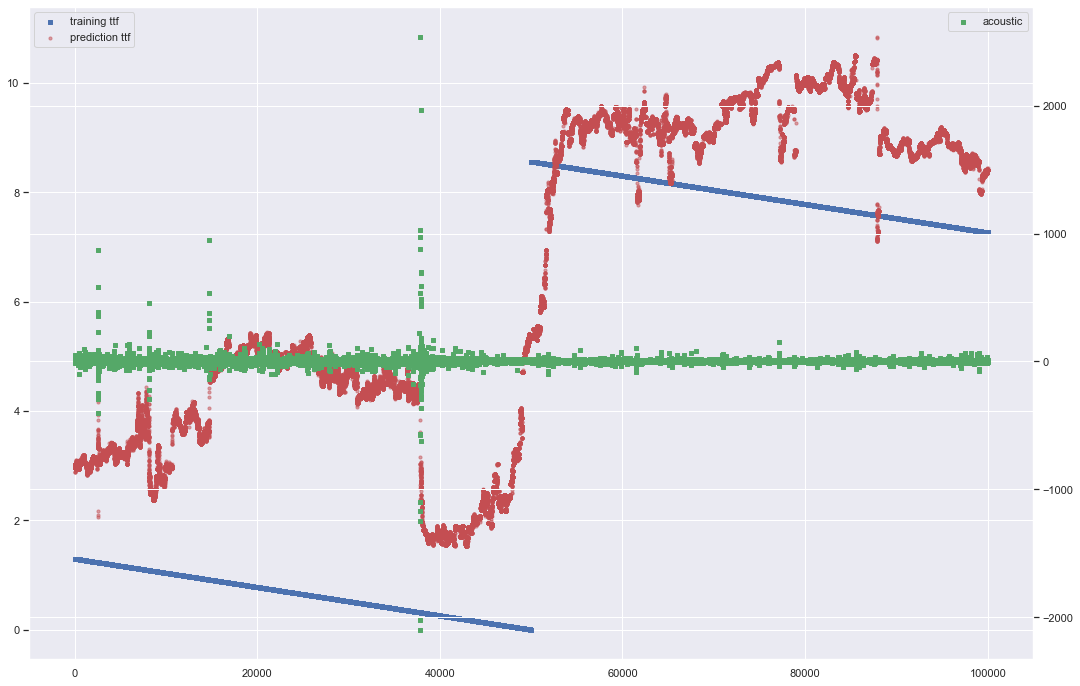

In [149]:
plot_rf_2(y_tt=np.append(rf_y_tr, rf_y_tt), preds=np.append(rf_preds_tr, rf_preds), start=4858004-50000, end=4858004+50000, ac_start=4858004, ac_end=4858004+100000)

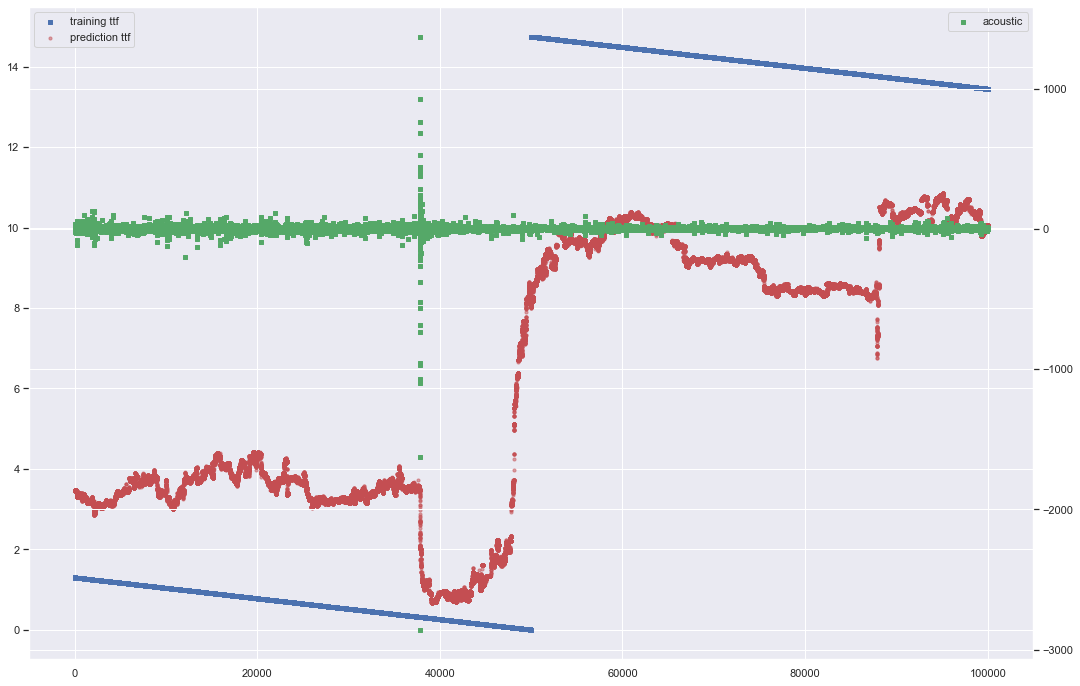

In [150]:
plot_rf_2(y_tt=np.append(rf_y_tr, rf_y_tt), preds=np.append(rf_preds_tr, rf_preds), start=5187773-50000, end=5187773+50000, ac_start=5187773, ac_end=5187773+100000)

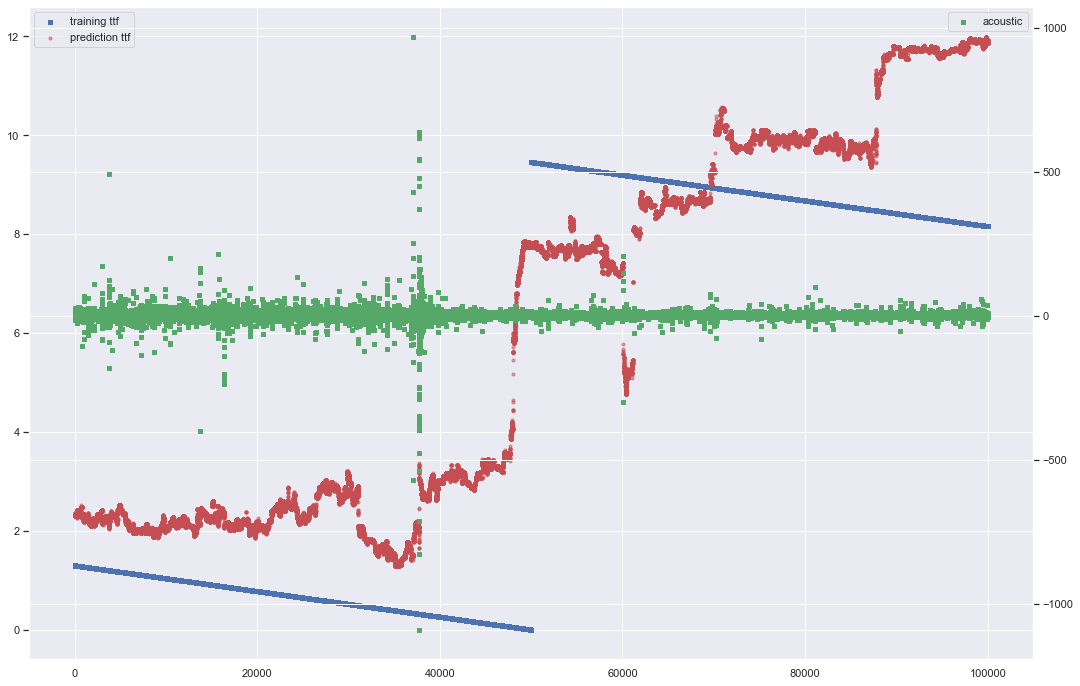

In [151]:
plot_rf_2(y_tt=rf_y_tt, preds=rf_preds, start=5755684-50000-len(rf_X_tr), end=5755684+50000-len(rf_X_tr), ac_start=5755684, ac_end=5755684+100000)

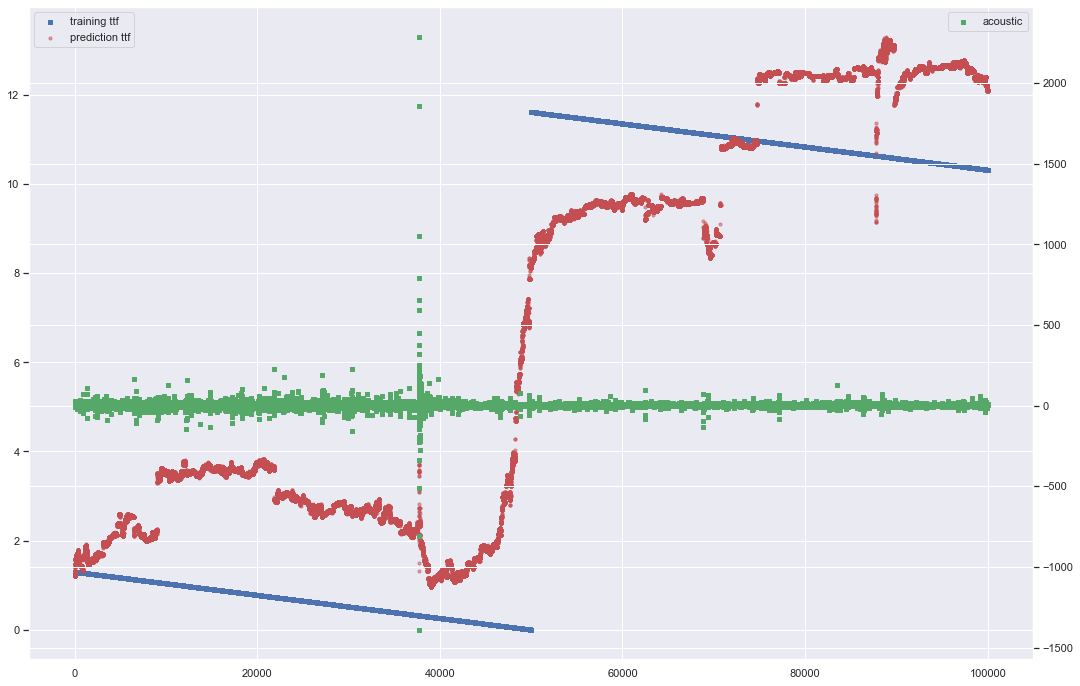

In [152]:
plot_rf_2(y_tt=rf_y_tt, preds=rf_preds, start=6119859-50000-len(rf_X_tr), end=6119859+50000-len(rf_X_tr), ac_start=6119859, ac_end=6119859+100000)

- Can show how this model is "good enough" by fairly accurately predicting the end of the ttf series


- Need to show the impact of the large impulse in the acoustic data and its impact on the predicted ttf series
    - Impact is noticeable, especially at the time of the impulse, but the model continue to predict ttf in a downward trend closer to the actual event
    - ***DONE***
    
    
- If they line up we can show a confidence interval for how much time to be added to the prediction based on the average for each event (possibly both in training and test sets, as the correlation is showing in both)
    - They do not correlate very much
    - ***DONE***

11/09/2022:
- Time to Failure is in seconds and need to think about how to scale that to real world events


- In relation to if the results are "good enough" can show ttf within a confidence interval or RMSE? 
    - Basically, how can we report on the accuracy of the models?
    - Need to determine the benefits of having this model as opposed to not having it at all
        - Basically, is it better than having nothing


- When using a gridseachCV, if you search for the best MSL at 100 n_estimators and decide to move to 1000 n_estimators can you use the same MSL or should a new gridsearchCV be performed?
    - If you get the MSL at a lower n_estimators and push the next model at the higher n_estimators then using the same MSL is fine as it is likely within the 95% confidence interval of the "best model" 
    - ***ANSWERED***


- Need to complete two other models and compare results per the rubric guidelines
    - Models are ready for hyperparameter tuning
    - ***DONE Modelling_6***


- Need to graph scatter plot the MSL scores
    - *****DONE Modelling_5*****


- Create more features off top feature importance std_10000
    - Run another gridsearchCV
    - ***DONE Modelling_6***
    

- Should also try taking semi-random, but consecutive data (i.e. instead of every 100th data we can select a random index for every 100 data points)
    - *****DONE Modelling_6*****
    - ***DID NOT IMPROVE RESULTS***


In [154]:
gscv_rsme_scores = {'mean_test_score': [-2.737426, -2.71419802, -2.67754078, -2.70943579, -2.68489331,
        -2.66312071, -2.66678709, -2.62995371, -2.6396307 , -2.66332397,
        -2.65248981, -2.67524986, -2.64914189, -2.65945565, -2.6388826,
        -2.66544357, -2.6452559, -2.63532238, -2.66115874, -2.66201618,
        -2.65059171, -2.63516164, -2.6314445 , -2.66025763, -2.62615634,
        -2.64985843, -2.6517609, -2.65972158, -2.64263696, -2.64389219,
        -2.64130155, -2.66054834, -2.6616977, -2.62434608, -2.65255302,
        -2.67932846, -2.62770598, -2.63743376]}

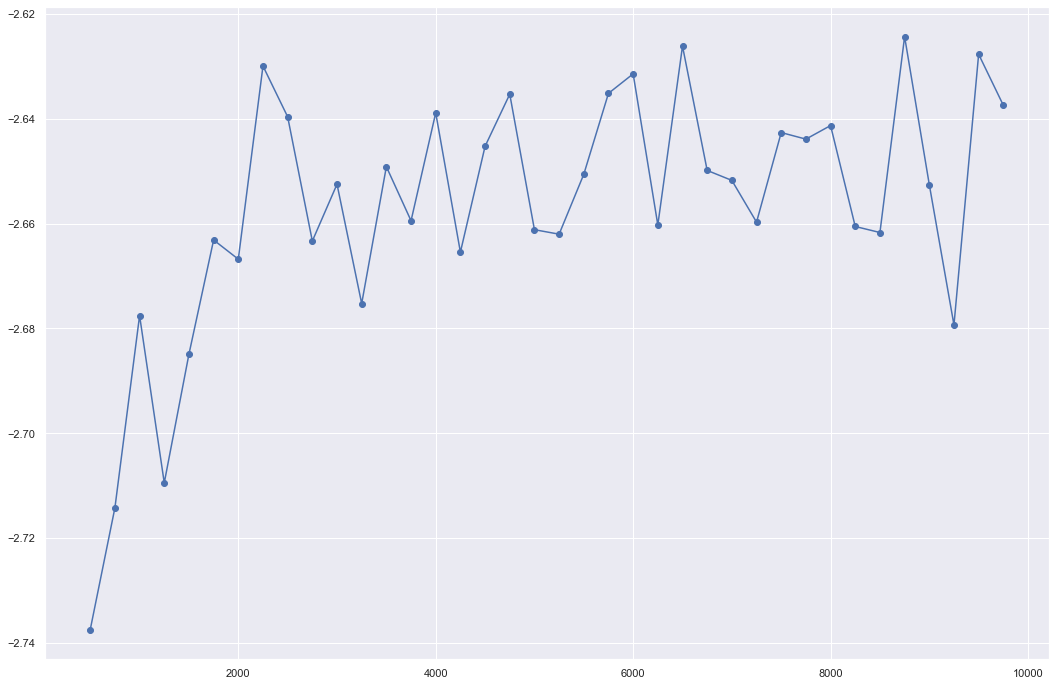

In [155]:
fig = plt.figure(figsize=(18, 12))

plt.plot(range(500, 10000, 250), gscv_rsme_scores['mean_test_score'], '-o')
plt.show()

### - The graph above shows there is no improvement to the RMSE after 2000 MSL

# Gradient Boosting Regressor

In [157]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import metrics 

- Use GridSearch for learning rate between 0.05 and 0.20 (can use 0.10 for default)


- Fix learning rate and number of estimators for tuning tree-based parameters
- In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:
    - min_samples_split = 500 : This should be ~0.5-1% of total values. Since this is imbalanced class problem, we’ll take a small value from the range.
    - min_samples_leaf = 50 : Can be selected based on intuition. This is just used for preventing overfitting and again a small value because of imbalanced classes.
    - max_depth = 8 : Should be chosen (5-8) based on the number of observations and predictors. This has 87K rows and 49 columns so lets take 8 here.
    - max_features = ‘sqrt’ : Its a general thumb-rule to start with square root.
    - subsample = 0.8 : This is a commonly used used start value

In [158]:
# Another predict function for manually set train and test sets

def gbr_predict(X, y, mf: float=3, ne: float=10, msl: float=50, md: float=5, lr: float=0.05):
    """
    Use a Gradient Boosting Regressor to predict time to failure on both the train set and test set
    Return the scores and performance metrics of the prediction
    """
    feature_importance_df = pd.DataFrame()
    scores_tt = []
    scores_tr = []
    rf_params = {}
    train_columns = X.columns.values
    
        
    # train and test splits per fold
    X_tr, X_tt = X.iloc[0:4568118], X.iloc[4618119:]
    y_tr, y_tt = y.iloc[0:4568118], y.iloc[4618119:]
        
    # model 
    gbr = GradientBoostingRegressor(max_features=mf, n_estimators=ne, max_depth=md, min_samples_leaf=msl, learning_rate=lr)
    
    gbr.fit(X_tr, y_tr)
    preds = gbr.predict(X_tt)
    preds_tr = gbr.predict(X_tr)
    
    fold_ = 0
    # performance scores
    scores_tt.append(rf_performance(X_tt=X_tt, y_tt=y_tt, preds=preds, fold_=fold_))
    scores_tr.append(rf_performance(X_tt=X_tr, y_tt=y_tr, preds=preds_tr, fold_=fold_))
    
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = gbr.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    return scores_tt, scores_tr, X_tr, X_tt, y_tr, y_tt, preds_tr, preds, feature_importance_df

In [136]:
X_grid = X.iloc[0:4568118].append(X.iloc[4618119:])

y_grid = y.iloc[0:4568118].append(y.iloc[4618119:])

In [133]:
from sklearn.model_selection import GridSearchCV

gbr_model = GradientBoostingRegressor()
param_search = {'max_features' : [3],
                'n_estimators' : [10],
                'min_samples_leaf' : [x for x in range(500, 3750, 750)],
                'learning_rate' : [0.1, 0.05, 0.01]
               }

grid_search = GridSearchCV(estimator = gbr_model, 
                           cv = ts_gs_cv, 
                           param_grid = param_search,
                           scoring = 'neg_root_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(X,y)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_features': [3],
                         'min_samples_leaf': [500, 1250, 2000, 2750, 3500],
                         'n_estimators': [10]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [134]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_features': 3,
 'min_samples_leaf': 500,
 'n_estimators': 10}

In [135]:
grid_search.cv_results_

{'mean_fit_time': array([40.08260083, 37.34423652, 39.08296146, 37.51551132, 38.98201919,
        37.06220021, 38.52119155, 37.0128674 , 37.58558121, 38.32619095,
        38.24513836, 37.63612065, 40.26811404, 38.94640312, 37.9886929 ]),
 'std_fit_time': array([18.86084421, 16.99964292, 19.49506586, 18.67709157, 18.84743635,
        18.26696884, 20.08828925, 18.30009115, 18.27005127, 18.07653167,
        17.85785592, 17.7538228 , 19.27903639, 19.97109599, 18.08254387]),
 'mean_score_time': array([0.27642112, 0.26682019, 0.26362095, 0.26162033, 0.26821942,
        0.25702   , 0.28262234, 0.26322007, 0.30362248, 0.27973824,
        0.26222   , 0.28481927, 0.29182191, 0.25461764, 0.25641952]),
 'std_score_time': array([0.02856458, 0.01490535, 0.00801576, 0.00326156, 0.01309293,
        0.0044274 , 0.04507522, 0.0059131 , 0.03912446, 0.01525459,
        0.00699862, 0.01761216, 0.02798433, 0.00662093, 0.00382603]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.

# Model 2 - Gradient Boosting Regression Model w/ gridsearch-cv best params

In [159]:
gbr_scores_tt, gbr_scores_tr, gbr_X_tr, gbr_X_tt, gbr_y_tr, gbr_y_tt, gbr_preds_tr, gbr_preds, gbr_feature_importance_df = gbr_predict(X=X, y=y, lr=0.1, msl=500, ne=100)

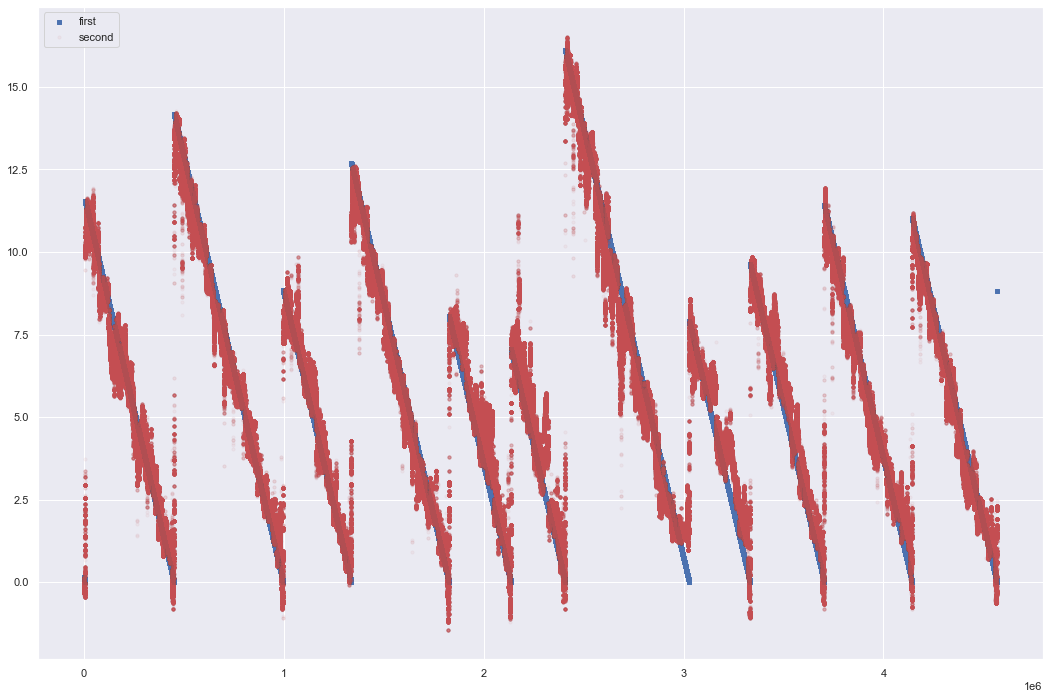

In [160]:
plot_rf(y_tt=gbr_y_tr, preds=gbr_preds_tr)

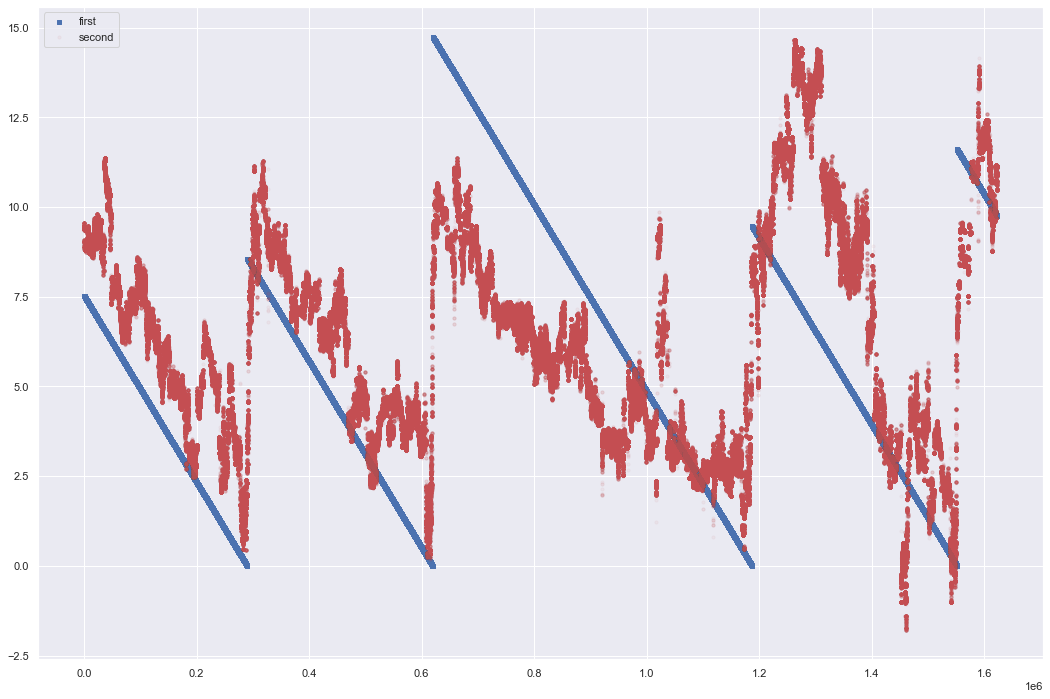

In [161]:
plot_rf(y_tt=gbr_y_tt, preds=gbr_preds)

In [162]:
gbr_scores_tt = pd.DataFrame(gbr_scores_tt)
gbr_scores_tt.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
gbr_scores_tt.set_index('fold', inplace=True)
gbr_scores_tt

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.376415930263347409123753,2.426746198019759326314215,8.407637744306294180773875,2.899592685931300817259171,4.865482280381022484050391


In [163]:
gbr_scores_tr = pd.DataFrame(gbr_scores_tr)
gbr_scores_tr.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
gbr_scores_tr.set_index('fold', inplace=True)
gbr_scores_tr

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.96393468445984764603196,0.521822620710921780684544,0.485255186975210417443805,0.696602603336515247001159,2.339355091850405354847453


# LightGBM Regressor

##### Main Features:
- Higher accuracy and a faster training speed.


- Low memory utilization


- Comparatively better accuracy than other boosting algorithms and handles overfitting much better while working with smaller datasets.


- Parallel Learning support.


- Compatible with both small and large datasets

In [165]:
import lightgbm as lgb

In [168]:
# Another predict function for manually set train and test sets

def lgbm_predict(X, y, ne: float=10, nl: float=16, md: float=4, 
                 lr: float=0.05, lambda_l1: float=50, lambda_l2: float=50):
    """
    Use a Gradient Boosting Regressor to predict time to failure on both the train set and test set
    Return the scores and performance metrics of the prediction
    """
    feature_importance_df = pd.DataFrame()
    scores_tt = []
    scores_tr = []
    rf_params = {}
    train_columns = X.columns.values
    
        
    # train and test splits per fold
    X_tr, X_tt = X.iloc[0:4568118], X.iloc[4618119:]
    y_tr, y_tt = y.iloc[0:4568118], y.iloc[4618119:]
        
    # model 
    lgbm = lgb.LGBMRegressor(n_estimators = ne, num_leaves=nl, max_depth=md, learning_rate=lr)
    
    lgbm.fit(X_tr, y_tr)
    preds = lgbm.predict(X_tt)
    preds_tr = lgbm.predict(X_tr)
    
    fold_ = 0
    # performance scores
    scores_tt.append(rf_performance(X_tt=X_tt, y_tt=y_tt, preds=preds, fold_=fold_))
    scores_tr.append(rf_performance(X_tt=X_tr, y_tt=y_tr, preds=preds_tr, fold_=fold_))
        
    # feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = lgbm.feature_importances_[:len(train_columns)]
    fold_importance_df["fold"] = fold_
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    return scores_tt, scores_tr, X_tr, X_tt, y_tr, y_tt, preds_tr, preds, feature_importance_df

In [147]:
X_grid = X.iloc[0:4568118].append(X.iloc[4618119:])

y_grid = y.iloc[0:4568118].append(y.iloc[4618119:])

In [149]:
# grid search on min_data_in_leaf to reduce overfitting

from sklearn.model_selection import GridSearchCV

lgb_model = lgb.LGBMRegressor()
param_search = {'n_estimators' : [100],
                'num_leaves' : [(2**x) for x in range(3, 8, 1)],    # num_leaves should be 2^x, where x is max_depth, 
                                                                    # but this is not always best in practice
                'learning_rate' : [0.1, 0.05, 0.01]
               }

grid_search = GridSearchCV(estimator = lgb_model, 
                           cv = ts_gs_cv, 
                           param_grid = param_search,
                           scoring = 'neg_root_mean_squared_error', 
                           return_train_score=True)

grid_search.fit(X,y)

[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_features
[LightGBM] [Warning] Unknown parameter: max_fe

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_features': [3], 'n_estimators': [100],
                         'num_leaves': [8, 16, 32, 64, 128]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [150]:
grid_search.best_params_

{'learning_rate': 0.05,
 'max_features': 3,
 'n_estimators': 100,
 'num_leaves': 8}

In [151]:
grid_search.cv_results_

{'mean_fit_time': array([14.72666345, 18.78530154, 27.09737687, 28.23593917, 38.19207082,
        22.68901353, 27.59463964, 23.38363285, 37.21430683, 39.49862819,
        24.31999569, 17.88447018, 34.35097871, 32.29805179, 44.67695503]),
 'std_fit_time': array([ 9.78860455, 14.16467091, 17.08882441, 19.63886751, 22.07563978,
        14.74250896, 21.32882403, 11.26546206, 16.79999587, 21.71463907,
        16.96137626, 10.27808454, 22.1940353 , 23.32684942, 25.19773013]),
 'mean_score_time': array([2.13996634, 1.28369761, 2.48048854, 3.24506836, 2.27641959,
        1.81086826, 1.33400345, 3.44439235, 3.4861135 , 1.87977619,
        1.36482191, 1.0391861 , 1.73312988, 1.40355873, 1.64523454]),
 'std_score_time': array([2.05078679, 0.04127874, 1.96244161, 2.83422876, 0.37778009,
        1.44043163, 0.18354499, 2.60419236, 2.19693598, 0.07457765,
        0.97364849, 0.05659783, 1.03354179, 0.05890499, 0.1221309 ]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.05, 0.

# Model 3 - Light Gradient Boosting Regression Model w/ gridsearch-cv best params

In [169]:
lgbm_scores_tt, lgbm_scores_tr, lgbm_X_tr, lgbm_X_tt, lgbm_y_tr, lgbm_y_tt, lgbm_preds_tr, lgbm_preds, lgbm_feature_importance_df = lgbm_predict(X=X, y=y, ne=100, lr=0.05, nl=8)

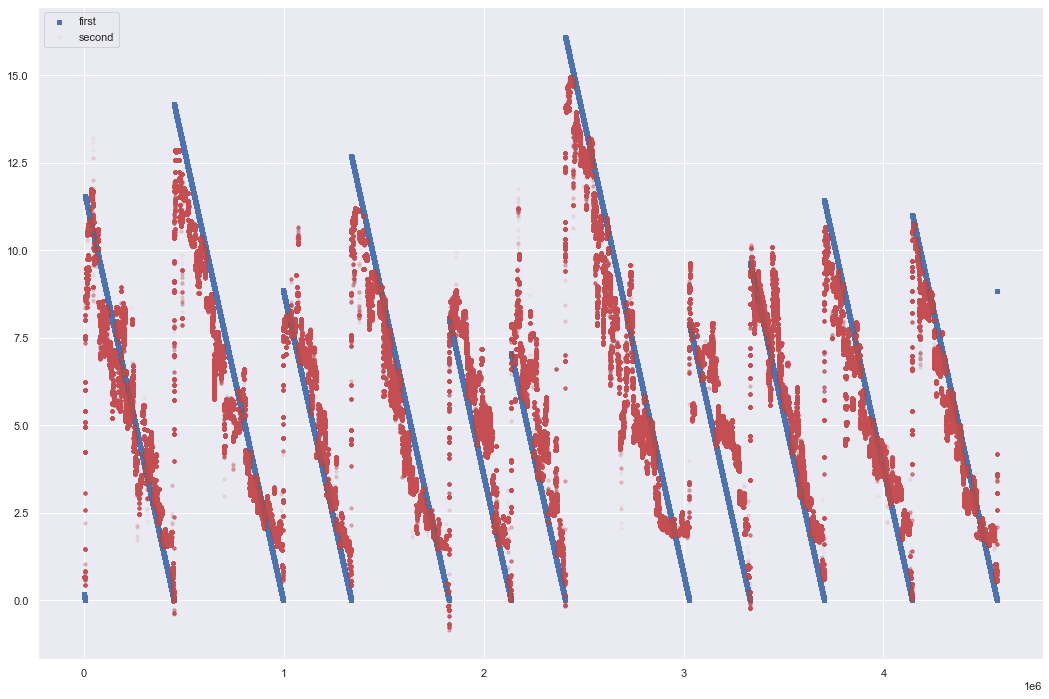

In [170]:
plot_rf(y_tt=lgbm_y_tr, preds=lgbm_preds_tr)

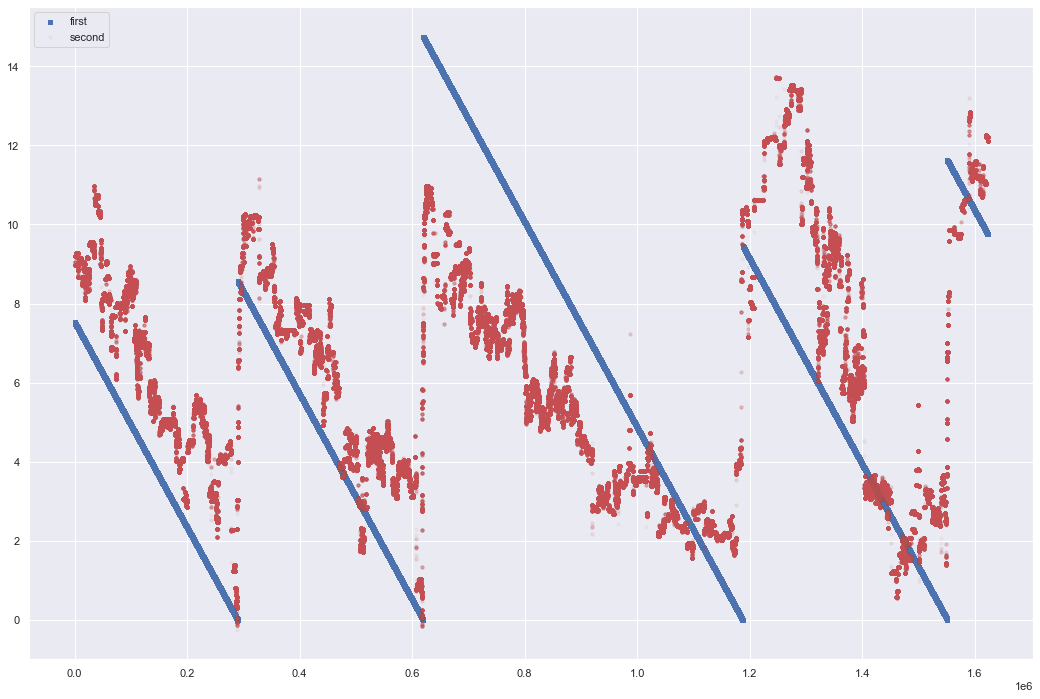

In [171]:
plot_rf(y_tt=lgbm_y_tt, preds=lgbm_preds)

In [172]:
lgbm_scores_tt = pd.DataFrame(lgbm_scores_tt)
lgbm_scores_tt.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
lgbm_scores_tt.set_index('fold', inplace=True)
lgbm_scores_tt

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.431199782865450909064009,2.337172265645344637619019,7.668999909779063983705782,2.769295923114585278312916,5.023012050327967159546461


In [173]:
lgbm_scores_tr = pd.DataFrame(lgbm_scores_tr)
lgbm_scores_tr.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
lgbm_scores_tr.set_index('fold', inplace=True)
lgbm_scores_tr

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.876654989496765679746204,1.030145518847193297773401,1.659594689184673788062696,1.288252571968973025917649,4.965761251273808518647002


## Making Predictions off random integers (random guesses)

- The idea is to show that the above models perform better than a simple guess and is better than "nothing"

- Could make a random integer within a probability distribution of the real value??


- ***NOT A CONVINCING WAY TO CREATE A BASELINE MODEL***

## Stub Baseline Model 
- RF Regression model
    - stub baseline of max_depth=2 
    - w/ few features
    - This can represent an if/else human predictor/decision maker

In [174]:
X_stub = X[['sm_avg_ser_896', 'sm_std_ser_896', 'rolling_q25', 'rolling_q50', 'rolling_q75']]

In [175]:
stub_rf_scores_tt, stub_rf_scores_tr, stub_rf_X_tr, stub_rf_X_tt, stub_rf_y_tr, stub_rf_y_tt, stub_rf_preds_tr, stub_rf_preds, stub_feature_importance_df = rf_predict_2(X=X_stub, y=y, mf=2)

In [176]:
stub_rf_scores_tt = pd.DataFrame(stub_rf_scores_tt)
stub_rf_scores_tt.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
stub_rf_scores_tt.set_index('fold', inplace=True)
stub_rf_scores_tt

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,-0.026559844603464277668081,3.037526590020601879871265,13.840865594790203729758105,3.720331382389236107854913,7.458736159889999051131326


In [177]:
stub_rf_scores_tr = pd.DataFrame(stub_rf_scores_tr)
stub_rf_scores_tr.columns = ['fold', 'r_2', 'MAE', 'MSE', 'RMSE', 'MAPE']
stub_rf_scores_tr.set_index('fold', inplace=True)
stub_rf_scores_tr

,r_2,MAE,MSE,RMSE,MAPE
fold,,,,,
0,0.588305823168312036486327,1.84923032154157640505332,5.539303670659702305556493,2.353572533545482681205385,5.213371036384922163620104


## RESULTS: MODEL PERFORMANCES

In [189]:
pd.set_option("display.precision", 5)

#### Performances on train data

In [196]:
all_scores_tr = pd.DataFrame()
all_scores_tr = all_scores_tr.append([rf_scores_tr, gbr_scores_tr, lgbm_scores_tr, stub_rf_scores_tr], ignore_index=True)
all_scores_tr.set_index(pd.Index(['Random Forest Model', 'Gradient Boost Model', 'Light GBM', 'Stub Baseline']), inplace=True)
all_scores_tr

,r_2,MAE,MSE,RMSE,MAPE
Random Forest Model,0.98369,0.28808,0.21940,0.46840,2.78926
Gradient Boost Model,0.96393,0.52182,0.48526,0.69660,2.33936
Light GBM,0.87665,1.03015,1.65959,1.28825,4.96576
Stub Baseline,0.58831,1.84923,5.53930,2.35357,5.21337


#### Performances on test data

In [197]:
all_scores_tt = pd.DataFrame()
all_scores_tt = all_scores_tt.append([rf_scores_tt, gbr_scores_tt, lgbm_scores_tt, stub_rf_scores_tt], ignore_index=True)
all_scores_tt.set_index(pd.Index(['Random Forest Model', 'Gradient Boost Model', 'Light GBM', 'Stub Baseline']), inplace=True)
all_scores_tt

,r_2,MAE,MSE,RMSE,MAPE
Random Forest Model,0.43443,2.37865,7.62551,2.76143,5.84878
Gradient Boost Model,0.37642,2.42675,8.40764,2.89959,4.86548
Light GBM,0.43120,2.33717,7.66900,2.76930,5.02301
Stub Baseline,-0.02656,3.03753,13.84087,3.72033,7.45874
